# Исследование удовлетворенности клиентов HR-аналитики компании «Работа с заботой». 

**Описание проекта**

 HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
 
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

Нам необходимо решить несколько задач: 
1. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
2. Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Шаг 1. Загрузка данных 

In [1]:
#!pip install phik==0.10.0 -q

In [2]:
#!pip install shap -q

In [3]:
#!pip install --upgrade scikit-learn -q

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt
import plotly.express as px
from scipy.stats import binom, poisson
from math import factorial

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import phik
import shap
from sklearn.metrics import make_scorer

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams ['figure.figsize'] = [10, 4]

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

## Задача 1: предсказание уровня удовлетворённости сотрудника

In [6]:
try:
    data_train = pd.read_csv('C:/Users/almuc/Downloads/train_job_satisfaction_rate.csv', decimal = ',')
    data_test = pd.read_csv('C:/Users/almuc/Downloads/test_features.csv', decimal = ',')
    data_target = pd.read_csv('C:/Users/almuc/Downloads/test_target_job_satisfaction_rate.csv', decimal = ',')
except:
    data_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal = ',')
    data_test = pd.read_csv('/datasets/test_features.csv', decimal = ',')
    data_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', decimal = ',')

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно. Отлично, что есть вариативность по источникам загрузки данных!</font>

**Проверим тренировочные данные.**

In [7]:
data_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   3994 non-null   object
 2   level                  3996 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   job_satisfaction_rate  4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


В таблице 4000 строк и 10 столбцов, пропуски в столбцах dept и level.

Посмотрим на наличие ошибок в заполнении данных.

In [9]:
data_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [10]:
data_train['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [11]:
data_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [12]:
data_train['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Ошибок в заполнении данных нет.

**Проверим тестовые данные.**

In [13]:
data_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [14]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В таблице 2000 строк и 9 столбцов, пропуски в столбцах dept и level.

In [15]:
data_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

У нас в столбце dept установлен пробел. Посмотрим на эту строку.

In [16]:
data_test_omissions = data_test.loc[(data_test['dept'] == " ")]
data_test_omissions

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


Заменим пробел на пропуск.

In [17]:
#data_test = data_test.replace(r'\s+', np.nan, regex=True)

In [18]:
data_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Отлично, все получилось. Проверяем дальше.

In [19]:
data_test['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [20]:
data_test['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [21]:
data_test['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Ошибок в заполнении данные нет.

**Проверим данные с целевым признаком**

In [22]:
data_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.6
3,555320,0.72
4,826430,0.08


In [23]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   job_satisfaction_rate  2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


В таблице 2000 строк и 2 столбца. Пропусков нет.

    Нам предосталены 3 таблицы с данными. 
    В первой таблице представлены тренировочные данные. В таблице 10 столбцов 4000 строк,  пропуски в столбцах dept и level. Ошибок в заполнении данных нет.
    Во второй таблице тестовые данные, В ней 9 столбцов и 2000 строк,  пропуски в столбцах dept и level. Ошибока в столбце dept установлен пробел. Пробел был заменен на nan.
    В третьей таблице данные о целевом признаке. В таблице 2000 строк и 2 столбца. Пропусков и ошибок нет.

## Шаг 2. Предобработка данных

Проведем проверку данных на наличие пропусков и дубликатов.

**Считаем количество пропущенных значений**

In [24]:
data_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Посмотрим сколько % занимают пропуски от общего количества строк.

In [25]:
pd.DataFrame(round(data_train.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
id,0.000000
dept,0.200000
level,0.100000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000
job_satisfaction_rate,0.000000


0.2 и 0.1 % от общего массива. Думаю такие пропуски незначительны, но по техническумо заданию пропуски необходимо заполнить с помощью паплайна. пропуски оставляем.

In [26]:
data_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Думаю 2 и 1 пропуск тоже не будут влиять на результат. Пропуски оставляем, так как это требуется в задании.

In [27]:
data_target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

В таблице с целевым признаком нет пропусков.

**Посчитаем наличие дубликатов.**

In [28]:
print('Количество явных дубликатов в тренировочных данных', data_train.duplicated().sum())

Количество явных дубликатов в тренировочных данных 0


In [29]:
print('Количество явных дубликатов в тестовых данных', data_test.duplicated().sum())

Количество явных дубликатов в тестовых данных 0


In [30]:
print('Количество явных дубликатов в целевом признаке', data_target.duplicated().sum())

Количество явных дубликатов в целевом признаке 0


Явные дубликаты не обнаружены.

**Проверим типы данных**

In [31]:
data_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2


In [32]:
data_train.dtypes

id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
job_satisfaction_rate    object
dtype: object

Переведем данные столбца job_satisfaction_rate в фомат float32.

In [33]:
data_train['job_satisfaction_rate'] = data_train['job_satisfaction_rate'].astype('float32')

In [34]:
data_train.dtypes

id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo           object
last_year_violations      object
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float32
dtype: object

Все получилось.

In [35]:
data_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [36]:
data_test.dtypes

id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
dtype: object

Данные в норме, изменять ничего не нужно.

In [37]:
data_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.6
3,555320,0.72
4,826430,0.08


In [38]:
data_target.dtypes

id                        int64
job_satisfaction_rate    object
dtype: object

Переведем данные столбца job_satisfaction_rate в фомат float32.

In [39]:
data_target['job_satisfaction_rate'] = data_target['job_satisfaction_rate'].astype('float32')

In [40]:
data_target.dtypes

id                         int64
job_satisfaction_rate    float32
dtype: object

Отсортируем тестовые и целевые данные по id.

In [41]:
data_test = data_test.sort_values(by=['id'])
data_target = data_target.sort_values(by=['id'])

In [42]:
data_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [43]:
data_target.head()

,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


Заполним пропуски на наиболее часто встречающиеся значения с помощью паплайна.

In [44]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

Данные приведены в норму.

По итогам предобработки данных могу сделать следующие выводы:
1. Пропуски в таблицах data_train и data_test, общее количество незначительно и не превышает 1 % от общего массива данных. По техническому заданию их нужно будет заполнить в паплайне.
2. Явные дубликаты в данных не выявлены.
3. Заменен тип данных в столбце job_satisfaction_rate в 1 и 3 таблице на формат float32.

## Шаг 3. Исследовательский анализ данных

Построим таблицы со статистическими данными.

**1. Тренировочные данные**

In [45]:
data_train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Есть сотрудники работающие в компании 10 лет. Посмотрим на этих сотрудников.

In [46]:
experience = data_train[data_train['employment_years'] >= 10]
experience

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
21,887667,sales,sinior,medium,10,no,no,4,52800,0.80
110,906885,technology,sinior,medium,10,no,no,4,62400,0.68
214,762793,sales,sinior,high,10,no,no,3,68400,0.41
458,338537,hr,middle,low,10,no,yes,3,24000,0.39
475,363647,sales,middle,medium,10,no,no,4,33600,0.69
...,...,...,...,...,...,...,...,...,...,...
3942,215496,technology,sinior,medium,10,no,yes,4,70800,0.63
3954,706200,purchasing,middle,high,10,no,yes,2,51600,0.13
3972,134106,hr,middle,high,10,no,yes,1,57600,0.39
3973,919388,sales,sinior,medium,10,no,no,5,60000,0.76


91 человек, довольно хороший костяк сотрдников работающих с начала работы компании. Построим гистограмму стажа работы.

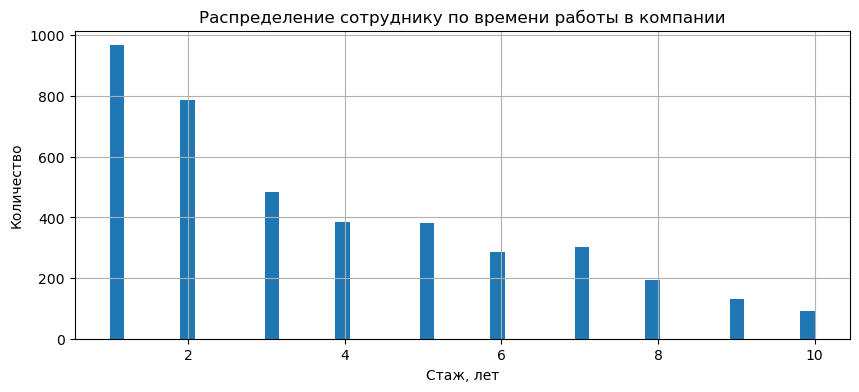

In [47]:
data_train['employment_years'].hist(bins=50)
plt.title("Распределение сотруднику по времени работы в компании")
plt.xlabel('Стаж, лет')
plt.ylabel('Количество')
plt.show()

Наибольшее количество сотрудников работает в компании до 3-х лет. Здесь возможно 2 варианта: либо 3 года назад началось масштабное расширение компании, что очень хорошо, либо сотрудники не задерживаются больше 3-х лет, что не очень хорошо. Возможные причины текучки кадров низкая зарплата, либо тяжелые условия труда.

Построим боксплот с уровнем зарплаты.

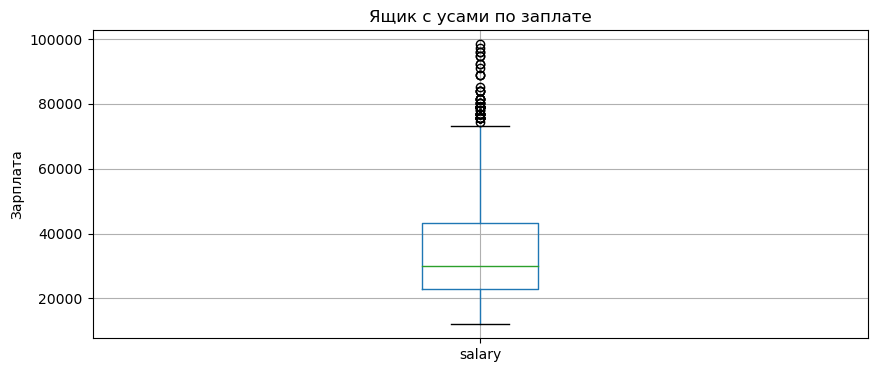

In [48]:
data_train.boxplot('salary')
plt.title("Ящик с усами по заплате")
plt.ylabel('Зарплата')
plt.show()

И гистограмму.

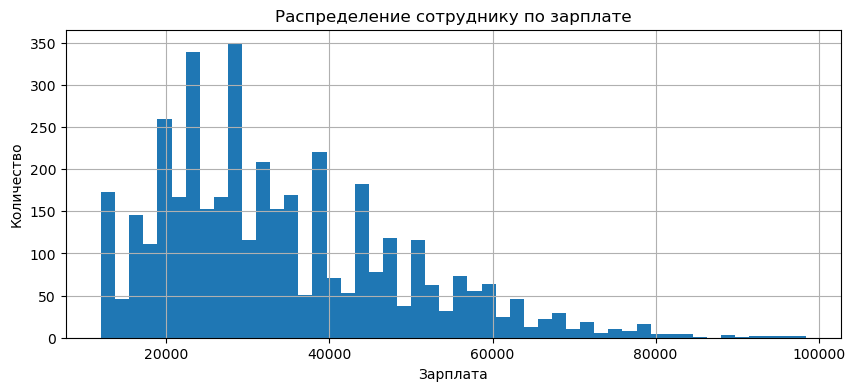

In [49]:
data_train['salary'].hist(bins=50)
plt.title("Распределение сотруднику по зарплате")
plt.xlabel('Зарплата')
plt.ylabel('Количество')
plt.show()

Большинство сотрудников получают зарплату в пределах от 20 до 40 тыс. руб. Также имеется группа лиц получающих больше 80 тысяч, максимум же составляет 98400 руб. Думаю больше 80 тысяч получают хорошие специалисты, ну а максимальная заплата у директора.

In [50]:
experience2 = data_train[data_train['salary'] >= 80000]
experience2

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
45,538347,technology,sinior,high,3,no,no,1,84000,0.21
141,128304,marketing,sinior,high,7,no,no,3,80400,0.48
360,405345,marketing,sinior,high,7,no,no,2,81600,0.58
1241,148024,technology,sinior,high,4,no,no,4,94800,0.67
1718,712878,purchasing,sinior,high,9,no,yes,4,80400,0.66
1799,494125,marketing,sinior,high,10,no,no,4,84000,0.81
1855,355174,technology,sinior,high,6,no,yes,4,88800,0.74
1899,642094,technology,sinior,high,6,no,no,5,88800,0.83
1981,961485,technology,sinior,high,9,no,no,3,84000,0.40
1982,978915,technology,sinior,high,7,no,no,1,92400,0.45


В таблице одни sinior с высоким уровнем нагрузки. Думаю это соответствует любой здравомыслящей логике. Эти данные не являются выбросами. Оставим все как есть.

Построим гистограму оценки работы сотрудника работодателем.

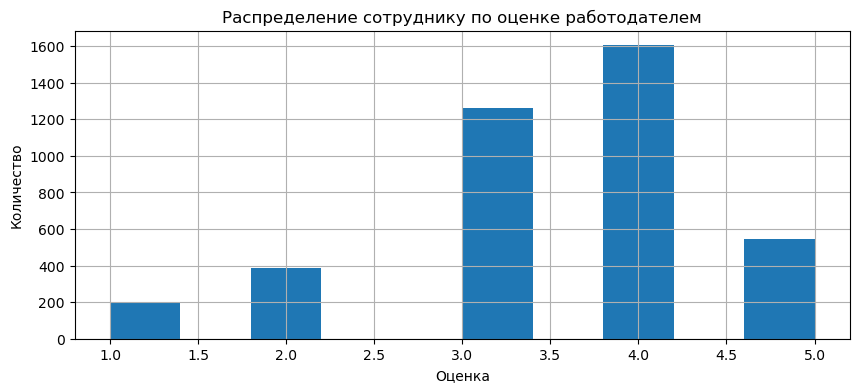

In [51]:
data_train['supervisor_evaluation'].hist()
plt.title("Распределение сотруднику по оценке работодателем")
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

Работодатель не особо щедр на оценки, большинство 3 и 4. Думаю это и есть причина того, что большинство персонала имеет стаж до 3-х лет.

Ну и самое главное, это уровень удовлетворённости сотрудника работой в компании, целевой признак. Построим гистограмму распределения.

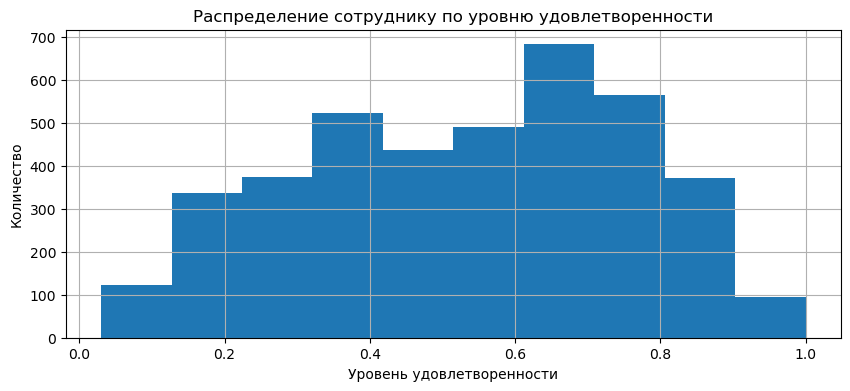

In [52]:
data_train['job_satisfaction_rate'].hist()
plt.title("Распределение сотруднику по уровню удовлетворенности")
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество')
plt.show()

Тут наблюдается 2 пика, от 0.6 до 0.8, т.е. те сотрудники, которые сомневаются "стоит ли уходить" и в 0,4 те которые думаю "стоит ли работать". Очень мало сотрудников настроены на работу и уход. Это очень обнадеживает, т.к. сомневающегося можно переубедить.

Посмотрим на соотношение сотрудников по департаменту.

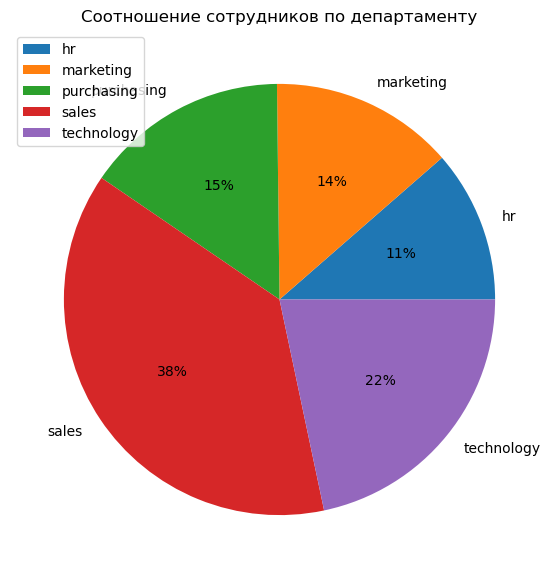

In [53]:
data_train.pivot_table(index='dept',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по департаменту")
plt.show()

Наибольшее количество сотрудников работает в продажах, 2 место занимают технологи. Значит компания занимается продажей чего либо.

Построим круговую диаграмму по профессиональному уровню сотрудников.

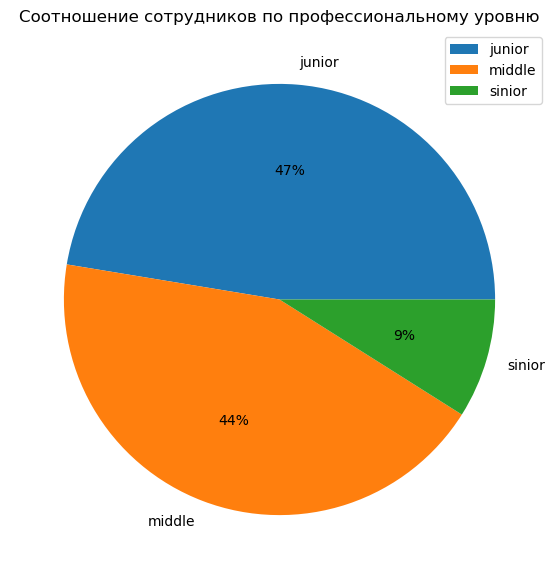

In [54]:
data_train.pivot_table(index='level',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по профессиональному уровню")
plt.show()

Большинство сотрудников новички и со средним опытом работы. Профессионалов всего 9 % от общего числа.

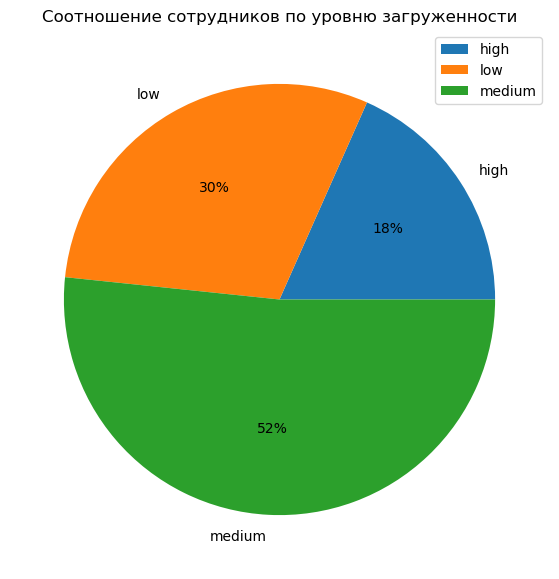

In [55]:
data_train.pivot_table(index='workload',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по уровню загруженности")
plt.show()

Более половины сотрудников загружено на работе средне.

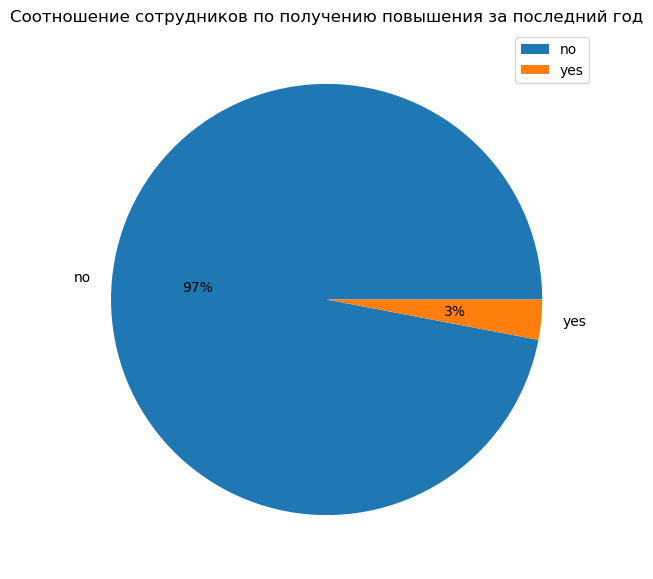

In [56]:
data_train.pivot_table(index='last_year_promo',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по получению повышения за последний год")
plt.show()

Всего 3 % сотрудников получили повышение за последний год. Думаю это не плохо, т.к. повышения даются либо в случае ухода начальника, что не очень хорошо, либо с открытием нового направления и увеличения штата, что не так часто бывает.

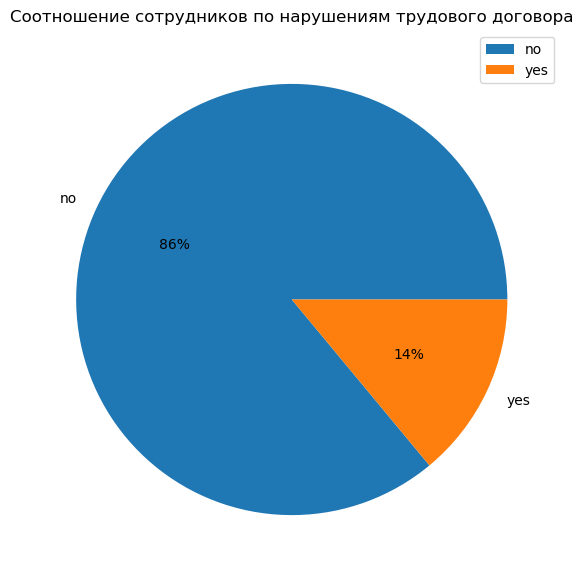

In [57]:
data_train.pivot_table(index='last_year_violations',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по нарушениям трудового договора")
plt.show()

14 % сотрудников за последний год нарушали трудовой договор. Нужно задуматься над данным показателем.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Хорошая работа в части исследования данных: применяешь подходящие для типов данных инструменты.</font>

**2. Тестовые данные.**

In [58]:
data_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Тестовые данные выглядят примерно как и тренировочные. Построим таблицы и посмотрим визуально на данные. 1 таблицу это стаж.

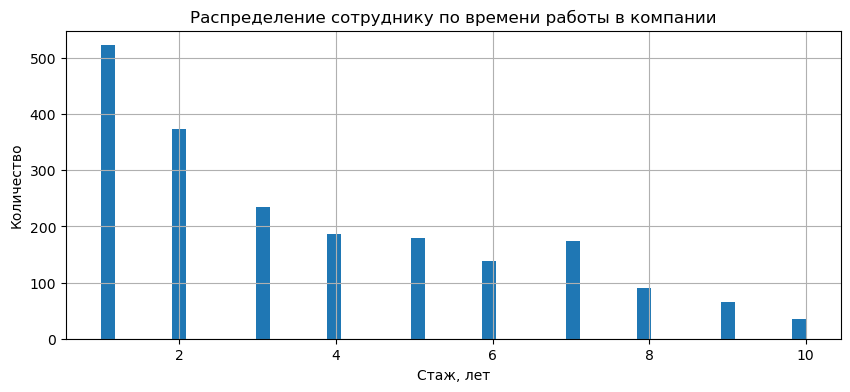

In [59]:
data_test['employment_years'].hist(bins=50)
plt.title("Распределение сотруднику по времени работы в компании")
plt.xlabel('Стаж, лет')
plt.ylabel('Количество')
plt.show()

Большинство сотрудников работают менее 4-х лет в компании.

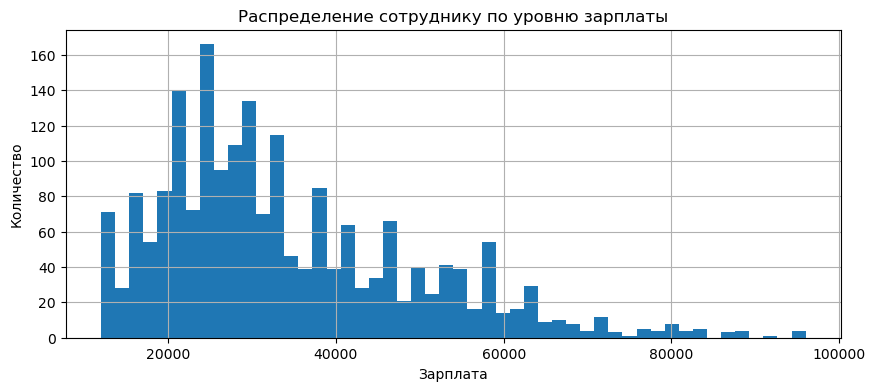

In [60]:
data_test['salary'].hist(bins=50)
plt.title("Распределение сотруднику по уровню зарплаты")
plt.xlabel('Зарплата')
plt.ylabel('Количество')
plt.show()

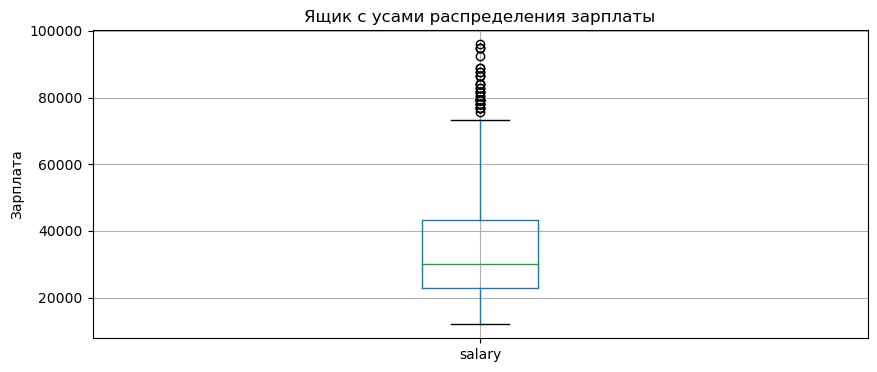

In [61]:
data_test.boxplot('salary')
plt.title("Ящик с усами распределения зарплаты")
plt.ylabel('Зарплата')
plt.show()

Уровень зарплаты такой же как и в тренировочных данных.

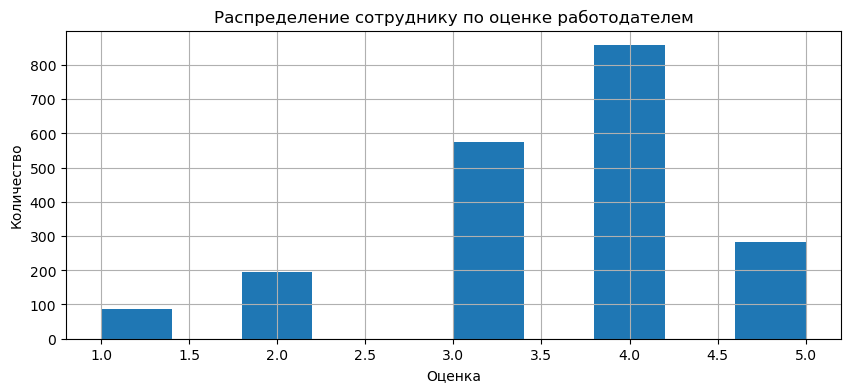

In [62]:
data_test['supervisor_evaluation'].hist()
plt.title("Распределение сотруднику по оценке работодателем")
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Здорово, что сравниваешь выборки!</font>

Лидером по оценкам является 4-ка, второе место занимает 3-ка. Работодатель также оценивает сотрудников.

Построим круговые диграммы для оценки категориальных признаков.

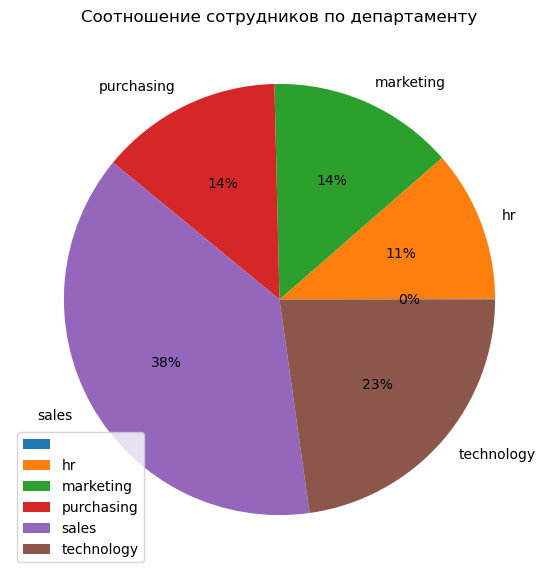

In [63]:
data_test.pivot_table(index='dept',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по департаменту")
plt.show()

В тестовых данных также преобладают сотрудники с отдела продаж.

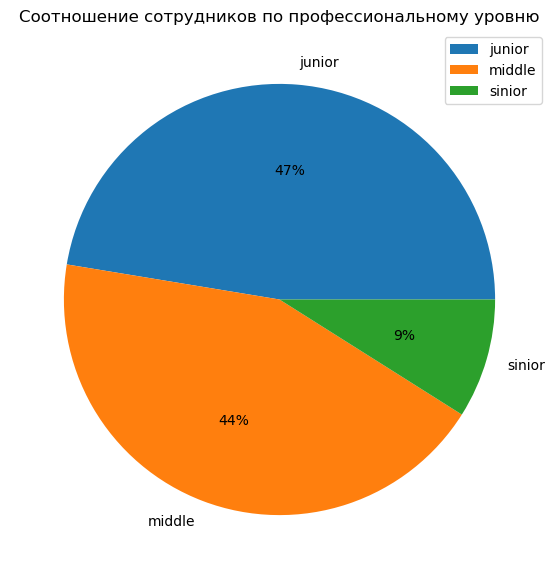

In [64]:
data_train.pivot_table(index='level',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по профессиональному уровню")
plt.show()

Распределение по профессиональному уровную точно такое же как и в тренировочных данных.

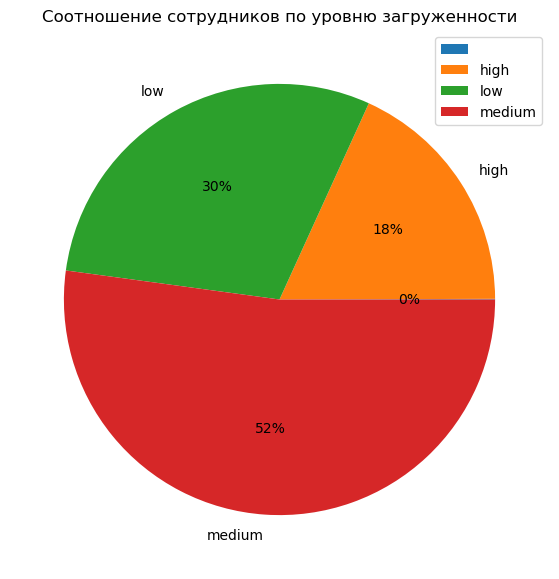

In [65]:
data_test.pivot_table(index='workload',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по уровню загруженности")
plt.show()

Загруженность на тестовых данных совпадает с тренировочными.

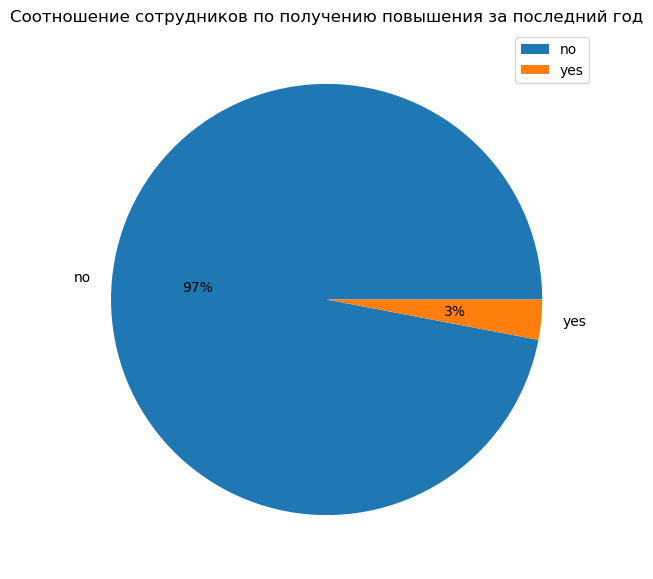

In [66]:
data_train.pivot_table(index='last_year_promo',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по получению повышения за последний год")
plt.show()

Также 3 % сотрудников получили за последний год повышение.

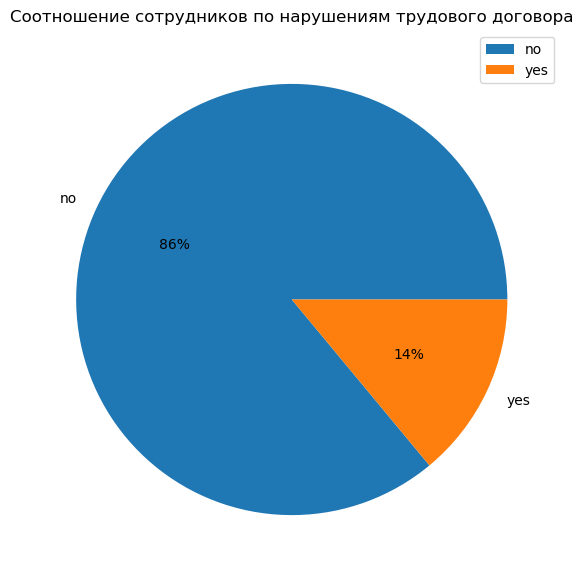

In [67]:
data_train.pivot_table(index='last_year_violations',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение сотрудников по нарушениям трудового договора")
plt.show()

14 % сотрудников нарушили трудовой договор за последний год.

**3. Целевой признак**

In [68]:
data_target.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


Построим гистограмму распределения оценок.

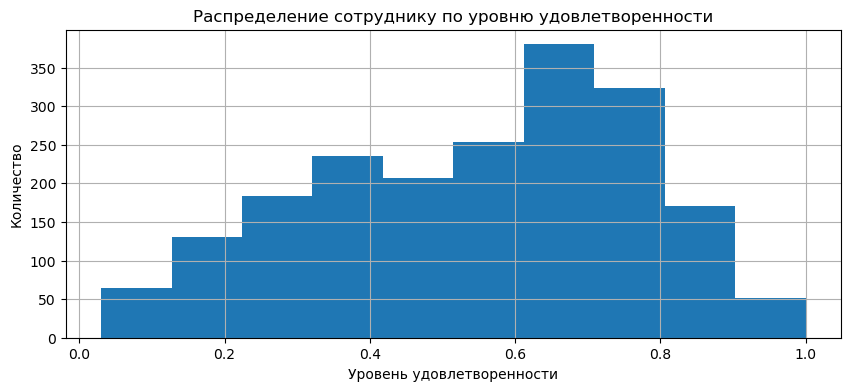

In [69]:
data_target['job_satisfaction_rate'].hist()
plt.title("Распределение сотруднику по уровню удовлетворенности")
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество')
plt.show()

Большинство сотрудников желает остаться работать. И сомневаются стоит ли уходить.

In [70]:
data_train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

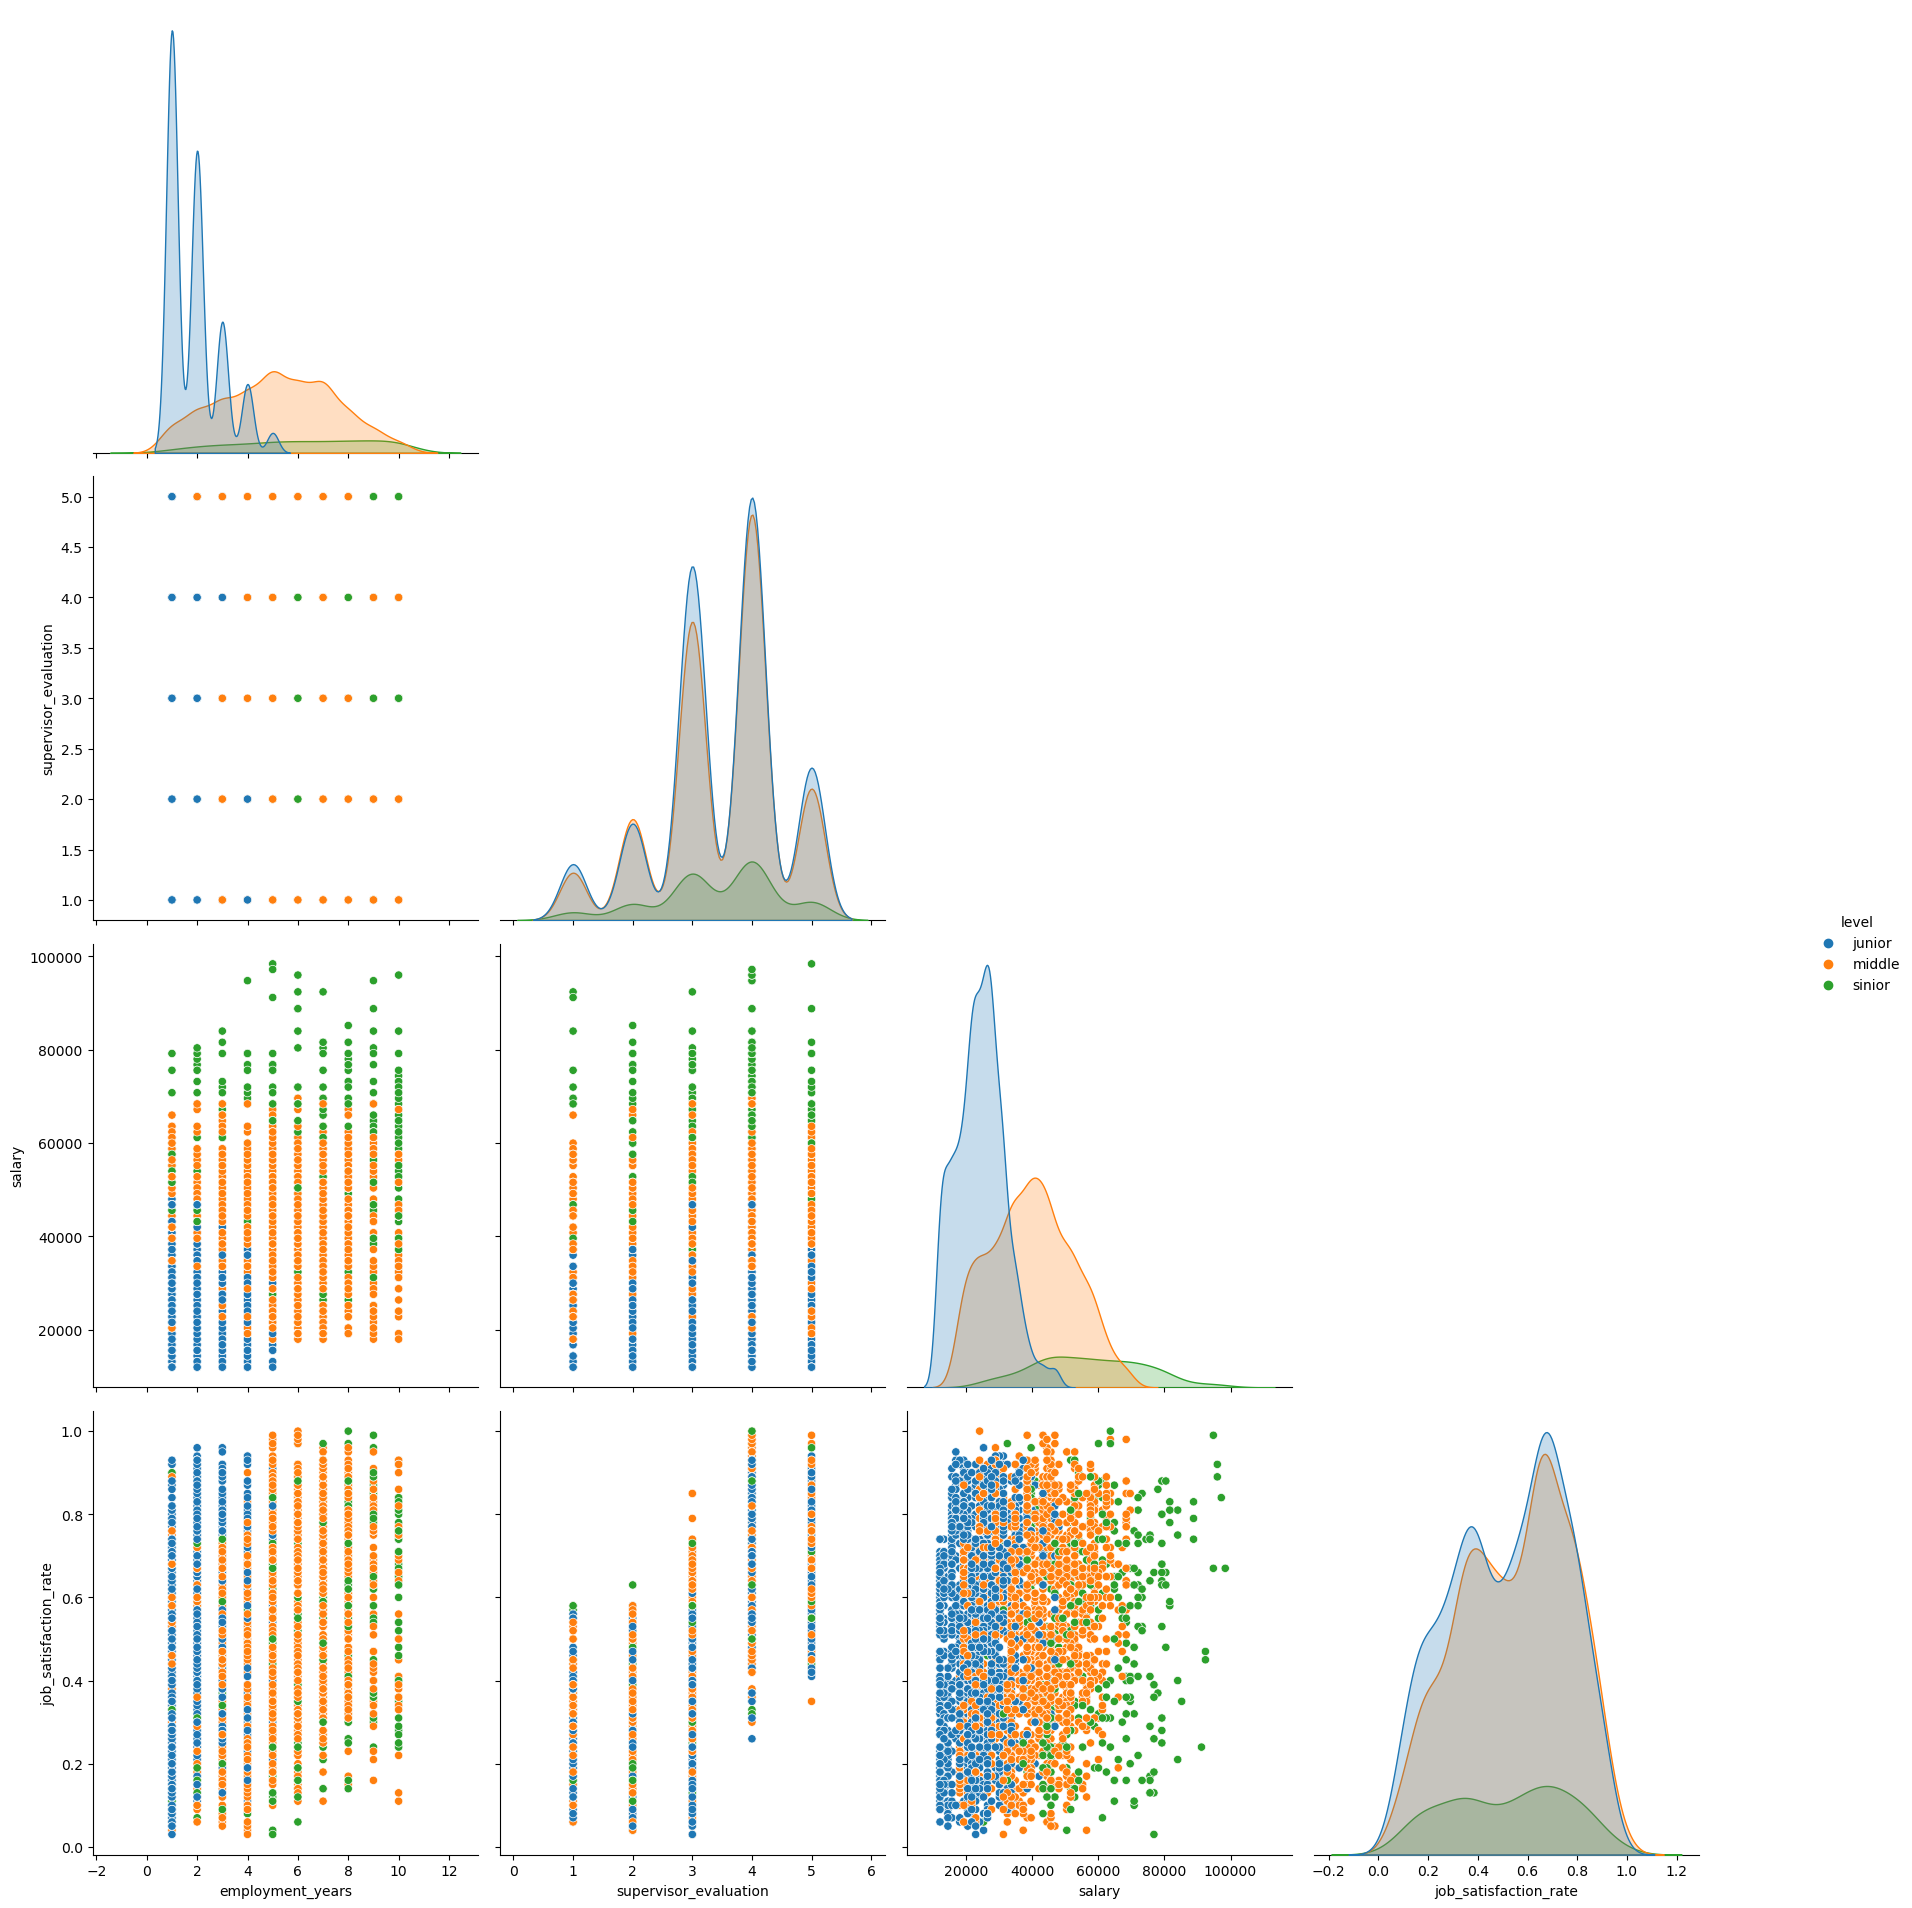

In [71]:
cols_numeric = ['level','employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate']
df = data_train[cols_numeric]
g = sns.pairplot(df, corner=True, hue="level")
g.fig.set_size_inches(20, 20)

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> ~~Нужен Анализ корреляций.~~</font>

In [72]:
cols_numeric2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
data_train.phik_matrix(interval_cols=cols_numeric2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
dept,1.0,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.271230,0.082086
level,1.0,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.712607,0.080620
workload,1.0,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.778527,0.056128
employment_years,1.0,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.473237,0.325603
last_year_promo,1.0,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.213295,0.190803
last_year_violations,1.0,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.018212,0.560348
supervisor_evaluation,1.0,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,1.0,0.271230,0.712607,0.778527,0.473237,0.213295,0.018212,0.000000,1.000000,0.143960
job_satisfaction_rate,1.0,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.143960,1.000000


Наиболее сильно на целевой признак влияет показатель оценка работодателя. Но он не линейнозависим, т.е. больше 0,9 поэтому оставляем данные как есть.

По итогам исследовательского анализа данных могу сказать следующее:
1. По тренировочным данным: 
    - 91 человек, довольно хороший костяк сотрудников работающих с начала работы компании. 
    - Наибольшее количество сотрудников работает в компании до 3-х лет. Здесь возможно 2 варианта: либо 3 года назад началось масштабное расширение компании, что очень хорошо, либо сотрудники не задерживаются больше 3-х лет, что не очень хорошо. Возможные причины текучки кадров низкая зарплата, либо тяжелые условия труда.
    - Работодатель не особо щедр на оценки, большинство 3 и 4. Думаю это и есть причина того, что большинство персонала имеет стаж до 3-х лет.
    - Большинство сотрудников получают зарплату в пределах от 20 до 40 тыс. руб. Также имеется группа лиц получающих больше 80 тысяч, максимум же составляет 98400 руб. Думаю больше 80 тысяч получают хорошие специалисты, ну а максимальная заплата у директора.
    - Наибольшее количество сотрудников работает в продажах, 2 место занимают технологи. Значит компания занимается продажей чего либо.
    - Более половины сотрудников загружено на работе средне.
    - Большинство сотрудников новички и со средним опытом работы. Профессионалов всего 9 % от общего числа.
    - Всего 3 % сотрудников получили повышение за последний год. Думаю это не плохо, т.к. повышения даются либо в случае ухода начальника, что не очень хорошо, либо с открытием нового направления и увеличения штата, что не так часто бывает.
    - 14 % сотрудников за последний год нарушали трудовой договор. Нужно задуматься над данным показателем.
    - Наиболее сильно на целевой признак влияет показатель оценка работодателя. Но он не линейнозависим, т.е. больше 0,9 поэтому оставляем данные как есть.
2. По тестовым данным:
    - Большинство сотрудников работают менее 4-х лет в компании.
    - Уровень зарплаты такой же как и в тренировочных данных.
    - Лидером по оценкам является 4-ка, второе место занимает 3-ка. Работодатель также оценивает сотрудников.
    - В тестовых данных также преобладают сотрудники с отдела продаж.
    - Загруженность на тестовых данных совпадает с тренировочными.
    - Также 3 % сотрудников получили за последний год повышение.
    - 14 % сотрудников нарушили трудовой договор за последний год.
3. По целевым данным:
    - Большинство сотрудников желает остаться работать. И сомневаются стоит ли уходить. Пик наблюдается от 0.6 до 0.8.

# Шаг 4. Подготовка данных

In [73]:
data_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [74]:
data_train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

Создаем списки.

In [75]:
data_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [76]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']

ord_columns = ['level', 
               'workload'
              ]

num_columns = ['salary', 'employment_years', 'supervisor_evaluation']

Переведем столбец id в индекс.

In [77]:
data_train = data_train.set_index('id')

In [78]:
print('Количество явных дубликатов в тренировочных данных', data_train.duplicated().sum())

Количество явных дубликатов в тренировочных данных 245


In [79]:
data_train = data_train.drop_duplicates()

In [80]:
print('Количество явных дубликатов в тренировочных данных', data_train.duplicated().sum())

Количество явных дубликатов в тренировочных данных 0


In [81]:
data_test = data_test.set_index('id')

In [82]:
data_target = data_target.set_index('id')

Построим паплайн для линейной регрессиии.

In [83]:
RANDOM_STATE = 13
X_train = data_train.drop(['job_satisfaction_rate'], axis=1)
y_train = data_train['job_satisfaction_rate']

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['medium', 'high', 'low']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

param_grid = [
 
    # словарь для модели LinearRegression
    {'models': [LinearRegression()],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 
    # словарь для модели DecisionTreeRegressor
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,5),
     'models__max_features': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 
    #словарь для модели RandomForestRegressor
    {'models': [RandomForestRegressor()],
     'models__n_estimators': range(2,10),
     'models__max_depth': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]

# Шаг 5. Обучение моделей

In [84]:
data_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [85]:
data_test = data_test.merge(data_target, on='id')

In [86]:
data_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80
100480,marketing,junior,low,4,no,no,4,16800,0.84
100503,purchasing,middle,high,5,no,no,4,55200,0.79
100610,sales,middle,medium,5,no,no,4,43200,0.75
100692,sales,middle,high,6,no,no,4,48000,0.69


In [87]:
y_test = data_target['job_satisfaction_rate']

Создадим метрику расчета модели

In [88]:
def smape_scorer(y_test, pred):
    metric = 100/len(y_test) * np.sum(2 * np.abs(pred - y_test) / (np.abs(y_test) + np.abs(pred)))
    return metric

scorer_smape = make_scorer(smape_scorer, greater_is_better=False)

In [89]:
#итоговый пайплайн: подготовка данных и модель
pipe_final2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
) 
 
param_grid2 = [
 
    {
     'models': [LinearRegression()],
     'models__fit_intercept': [True, False], 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
 
]

random_search = RandomizedSearchCV(
    pipe_final2, 
    param_grid2, 
    cv=5,
    scoring=scorer_smape,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика smape лучшей модели на тренировочной выборке:', abs(random_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

In [90]:
result = pd.DataFrame(random_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']]
            .sort_values('rank_test_score').head(10))

,rank_test_score,param_models,mean_test_score,params
5,1,LinearRegression(fit_intercept=False),-26.212966,"{'preprocessor__num': 'passthrough', 'models__fit_intercept': False, 'models': LinearRegression(fit_intercept=False)}"
1,2,LinearRegression(fit_intercept=False),-26.654139,"{'preprocessor__num': MinMaxScaler(), 'models__fit_intercept': True, 'models': LinearRegression(fit_intercept=False)}"
0,3,LinearRegression(fit_intercept=False),-26.654139,"{'preprocessor__num': StandardScaler(), 'models__fit_intercept': True, 'models': LinearRegression(fit_intercept=False)}"
2,4,LinearRegression(fit_intercept=False),-26.654139,"{'preprocessor__num': 'passthrough', 'models__fit_intercept': True, 'models': LinearRegression(fit_intercept=False)}"
4,5,LinearRegression(fit_intercept=False),-28.098792,"{'preprocessor__num': MinMaxScaler(), 'models__fit_intercept': False, 'models': LinearRegression(fit_intercept=False)}"
3,6,LinearRegression(fit_intercept=False),-44.553740,"{'preprocessor__num': StandardScaler(), 'models__fit_intercept': False, 'models': LinearRegression(fit_intercept=False)}"


Для линейной модели наилучшее абсолютное отклонение равно 26,2 %. Лучшие параметры LinearRegression(fit_intercept=False).

In [91]:
#итоговый пайплайн: подготовка данных и модель
pipe_final3 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 
 
param_grid3 = [
    {
     'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 50),
     'models__max_features': range(2, 50),
     'models__min_samples_split': [2, 6, 12],  
     'models__min_samples_leaf': [1, 5, 10], 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
 
]

random_search_tree = RandomizedSearchCV(
    pipe_final3, 
    param_grid3, 
    cv=5,
    scoring=scorer_smape,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search_tree.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', random_search_tree.best_estimator_)
print ('Метрика smape лучшей модели на тренировочной выборке:', abs(random_search_tree.best_score_))
print ('Метрика smape лучшей модели на тестовой выборке:', abs(scorer_smape(random_search_tree, data_test.drop('job_satisfaction_rate', axis= 1),
                                                                           data_test['job_satisfaction_rate'])))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Для Дерева решений симметричная средняя абсолютная процентная ошибка равно 15.08. Параметры модели DecisionTreeRegressor(max_depth=27, max_features=28, min_samples_split=6, random_state=13))]). Могу сделать вывод, что для наших данных больше подходит модель деревья решений.

# Шаг 6. Оформление выводов

По первой задаче построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, можно сделать следующие выводы:
1. По итогам предобработки данных могу сделать следующие выводы:
    - Пропуски в таблицах data_train и data_test, общее количество незначительно и не превышает 1 % от общего массива данных. По техническому заданию их нужно будет заполнить в паплайне.
    - Явные дубликаты в данных не выявлены.
    - Заменен тип данных в столбце job_satisfaction_rate в 1 и 34 таблице на формат float32.
2. По итогам исследовательского анализа данных могу сказать следующее:
    1. По тренировочным данным:
        - 91 человек, довольно хороший костяк сотрудников работающих с начала работы компании.
        - Наибольшее количество сотрудников работает в компании до 3-х лет. Здесь возможно 2 варианта: либо 3 года назад началось масштабное расширение компании, что очень хорошо, либо сотрудники не задерживаются больше 3-х лет, что не очень хорошо. Возможные причины текучки кадров низкая зарплата, либо тяжелые условия труда.
        - Работодатель не особо щедр на оценки, большинство 3 и 4. Думаю это и есть причина того, что большинство персонала имеет стаж до 3-х лет.
        - Большинство сотрудников получают зарплату в пределах от 20 до 40 тыс. руб. Также имеется группа лиц получающих больше 80 тысяч, максимум же составляет 98400 руб. Думаю больше 80 тысяч получают хорошие специалисты, ну а максимальная заплата у директора.
        - Наибольшее количество сотрудников работает в продажах, 2 место занимают технологи. Значит компания занимается продажей чего либо.
        - Более половины сотрудников загружено на работе средне.
        - Большинство сотрудников новички и со средним опытом работы. Профессионалов всего 9 % от общего числа.
        - Всего 3 % сотрудников получили повышение за последний год. Думаю это не плохо, т.к. повышения даются либо в случае ухода начальника, что не очень хорошо, либо с открытием нового направления и увеличения штата, что не так часто бывает.
        - 14 % сотрудников за последний год нарушали трудовой договор. Нужно задуматься над данным показателем.
        - Наиболее сильно на целевой признак влияет показатель оценка работодателя. Но он не линейнозависим, т.е. больше 0,9 поэтому оставляем данные как есть.
    2. По тестовым данным:
        - Большинство сотрудников работают менее 4-х лет в компании.
        - Уровень зарплаты такой же как и в тренировочных данных.
        - Лидером по оценкам является 4-ка, второе место занимает 3-ка. Работодатель также оценивает сотрудников.
        - В тестовых данных также преобладают сотрудники с отдела продаж.
        - Загруженность на тестовых данных совпадает с тренировочными.
        - Также 3 % сотрудников получили за последний год повышение.
        - 14 % сотрудников нарушили трудовой договор за последний год.
    3. По целевым данным:
        - Большинство сотрудников желает остаться работать. И сомневаются стоит ли уходить. Пик наблюдается от 0.6 до 0.8.
3. Наилучшая модель с гиперпараметрами для предсказания RandomForestRegressor(max_depth=4, n_estimators=6)).
4. При обучении моделей было построено 2 модели: Линейная модель и Дерево решений. Могу сделать следющте выводы:
    - Для линейной модели наилучшее абсолютное отклонение равно 26,2 %. Лучшие параметры LinearRegression(fit_intercept=False).
    - Для Дерева решений абсолютное отклонение равно 15.08. Параметры модели DecisionTreeRegressor(max_depth=27, max_features=28, min_samples_split=6, random_state=13))]). Могу сделать вывод, что для наших данных больше подходит модель деревья решений.

# Задача 2: предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

In [92]:
try:
    df_train = pd.read_csv('C:/Users/almuc/Downloads/train_quit.csv', decimal = ',')
    df_test = pd.read_csv('C:/Users/almuc/Downloads/test_features.csv', decimal = ',')
    df_target = pd.read_csv('C:/Users/almuc/Downloads/test_target_quit.csv', decimal = ',')
except:
    df_train = pd.read_csv('/datasets/train_quit.csv', decimal = ',')
    df_test = pd.read_csv('/datasets/test_features.csv', decimal = ',')
    df_target = pd.read_csv('/datasets/test_target_quit.csv', decimal = ',')

**Проверим тренировочные данные.**

In [93]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [94]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


В таблице 4000 строк и 10 столбцов. Пропуски отсутвуют.

Проверим верность заполнения данных.

In [95]:
df_train['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [96]:
df_train['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [97]:
df_train['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [98]:
df_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [99]:
df_train['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [100]:
df_train['quit'].unique()

array(['no', 'yes'], dtype=object)

Ошибок в заполнении данных нет.

**Тестовые данные**

Так как тестовые данные во второй задаче совпали с данными с первой задачи, то просто выведем данные для наглядности. Предобработку уже сделали.

In [101]:
df_test = df_test.sort_values(by=['id'])

In [102]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [103]:
df_test['dept'].unique()

array(['hr', 'marketing', 'purchasing', 'sales', 'technology', nan, ' '],
      dtype=object)

In [104]:
df_test['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [105]:
df_test['workload'].unique()

array(['low', 'high', 'medium', ' '], dtype=object)

Пробел нужно заменить на пропуск.

In [106]:
#df_test = df_test.replace(r'\s+', np.nan, regex=True)

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'>~~Это делается в Pipeline.~~</font>

<font color='blue'><b>Комментарий ревьюера 3: </b></font> ✔️\
<font color='green'> 👍</font>

In [107]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


In [108]:
df_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000
...,...,...,...,...,...,...,...,...,...
1925,997290,sales,sinior,medium,7,no,no,4,58800
1886,998548,marketing,junior,medium,2,no,no,4,32400
506,998762,technology,junior,low,3,no,no,3,22800
1579,998900,marketing,middle,medium,7,no,no,3,45600


В таблице 2000 строк и 9 столбцов. Пропуски в столбцах dept и level. Пропуски по заданию заполняются с помощью паплайна в шаге "Предобработка данных.

**Целевой признак тестовой выборки**

In [109]:
df_target = df_target.sort_values(by=['id'])

In [110]:
df_target.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


In [111]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1566 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


В таблице 2000 строк и 2 столбца. Пропуски отсутствуют.

Проверим верность заполнения данных.

In [112]:
df_target['quit'].unique()

array(['no', 'yes'], dtype=object)

Ошибок в заполнении данных нет.

    Во второй задаче нам предосталены 3 таблицы с данными. 
    В первой таблице представлены тренировочные данные. В таблице 10 столбцов 4000 строк,  пропусков нет. Ошибок в заполнении данных нет.
    Во второй таблице тестовые данные, В ней 9 столбцов и 2000 строк,  пропуски в столбцах dept и level. Ошибка в столбце dept установлен пробел. Пробел был заменен на nan. Проверка данных осуществлялась в 1 задаче.
    В третьей таблице данные о целевом признаке. В таблице 2000 строк и 2 столбца. Пропусков и ошибок нет.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

## Шаг 2. Предобработка данных

Проведем проверку данных на наличие пропусков и дубликатов.

**Считаем количество пропущенных значений**

In [113]:
df_train.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

В тренировочных данных пропущенных значений нет.

In [114]:
df_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [115]:
df_test['workload'].unique()

array(['low', 'high', 'medium', ' '], dtype=object)

В тестовых данных имеются пропуски значений в столбцах dept и level, workload. Пропуски будут заменяться с помощью паплайна на наиболее встречающиеся.

In [116]:
df_target.isna().sum()

id      0
quit    0
dtype: int64

В целевом признаке пропусков нет.

**Посчитаем наличие дубликатов.**

In [117]:
print('Количество явных дубликатов в обучающих данных', df_train.duplicated().sum())

Количество явных дубликатов в обучающих данных 0


In [118]:
print('Количество явных дубликатов в тестовых данных', df_test.duplicated().sum())

Количество явных дубликатов в тестовых данных 0


In [119]:
print('Количество явных дубликатов в данных с целевым признаком', df_target.duplicated().sum())

Количество явных дубликатов в данных с целевым признаком 0


Явных дубликатов в данных нет.

**Проверим типы данных**

In [120]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [121]:
df_train.dtypes

id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
quit                     object
dtype: object

В тренировочных данных все в порядке.

In [122]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [123]:
df_test.dtypes

id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
dtype: object

В тестовых данных все в порядке.

In [124]:
df_target.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


In [125]:
df_target.dtypes

id       int64
quit    object
dtype: object

Данные в порядке.

Создадим паплайн для заполнения пропусков данных.

In [126]:
ohe_pipe_quit = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

    По предобработке данных могу сказать следующее: 
    - Пропуски только в тестовых данных в столбцах dept и level. 
    - Явных дубликатов не выявлено.
    - Типы данных в норме.
    - Был написан паплайн для заполнения пропусков на наиболее часто встречающиеся значения.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

## Шаг 3. Исследовательский анализ данных

**Тренировочные данные**

Посмотрим на данные в разрезе 2-х таблиц, тех кто остался и уволился.

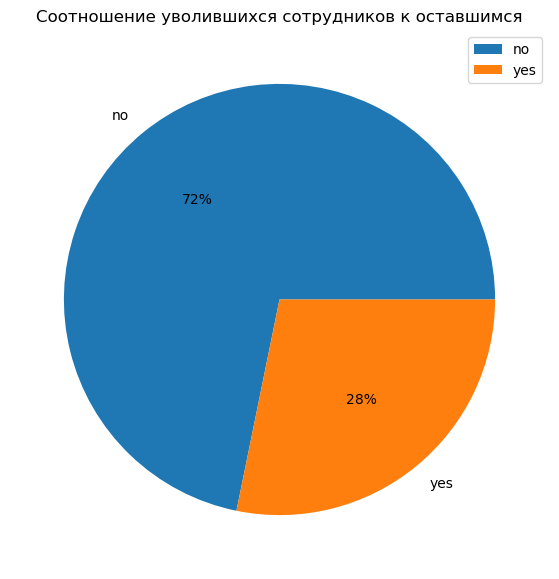

In [127]:
df_target.pivot_table(index='quit',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение уволившихся сотрудников к оставшимся")
plt.show()

28 % сотрудников уволились в тренировочных данных.

In [128]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [129]:
stayed = df_train.query("quit == 'no'")
dismissal = df_train.query("quit == 'yes'")

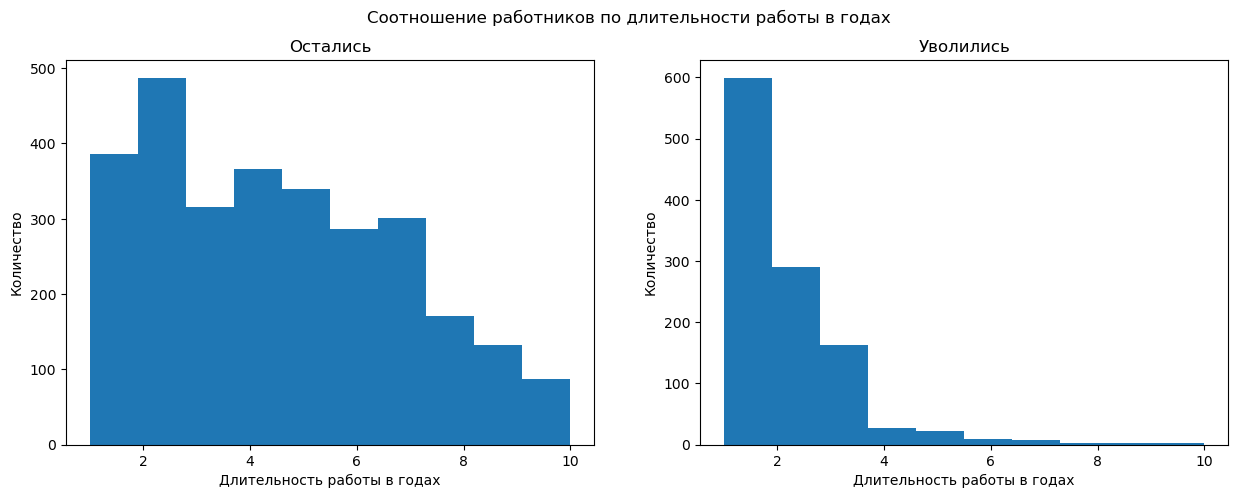

In [130]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Соотношение работников по длительности работы в годах')

plt.subplot(1, 2, 1)
plt.hist(stayed['employment_years'])
plt.title('Остались')
plt.xlabel('Длительность работы в годах')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(dismissal['employment_years'])
plt.title('Уволились')
plt.xlabel('Длительность работы в годах')
plt.ylabel('Количество')

plt.show()

Ничего удивительного в графике нет. В основном увольняются сотрудники на первых 3-х годах работы в компании, причем абсолютное большинство в 1 год работы. Однако, среди тех кто остался наибольшее количество сотрудников работает 2 года, это хороши признак, т.к.в первый год отсеились все не готовые работать сотрудники. Оставшиеся сотрудники после 2 года реже увольняются и возможно остатнутся работать дальше.

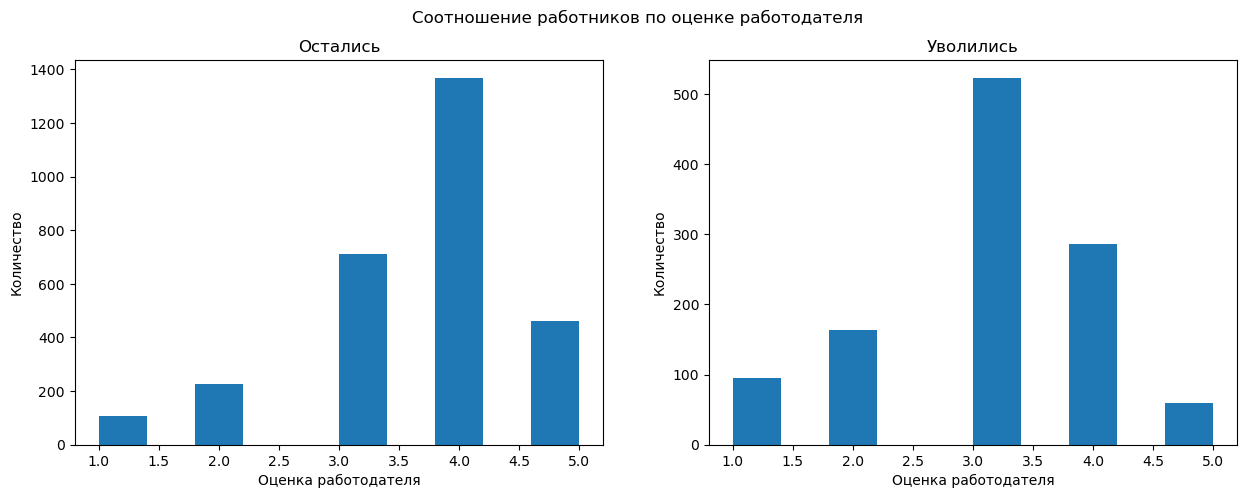

In [131]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Соотношение работников по оценке работодателя')

plt.subplot(1, 2, 1)
plt.hist(stayed['supervisor_evaluation'])
plt.title('Остались')
plt.xlabel('Оценка работодателя')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(dismissal['supervisor_evaluation'])
plt.title('Уволились')
plt.xlabel('Оценка работодателя')
plt.ylabel('Количество')

plt.show()

У тех кто остался преобладает оценка 4 за работу, кто остался 3. Наверное работники не особо старались и уже собирались уволиться.

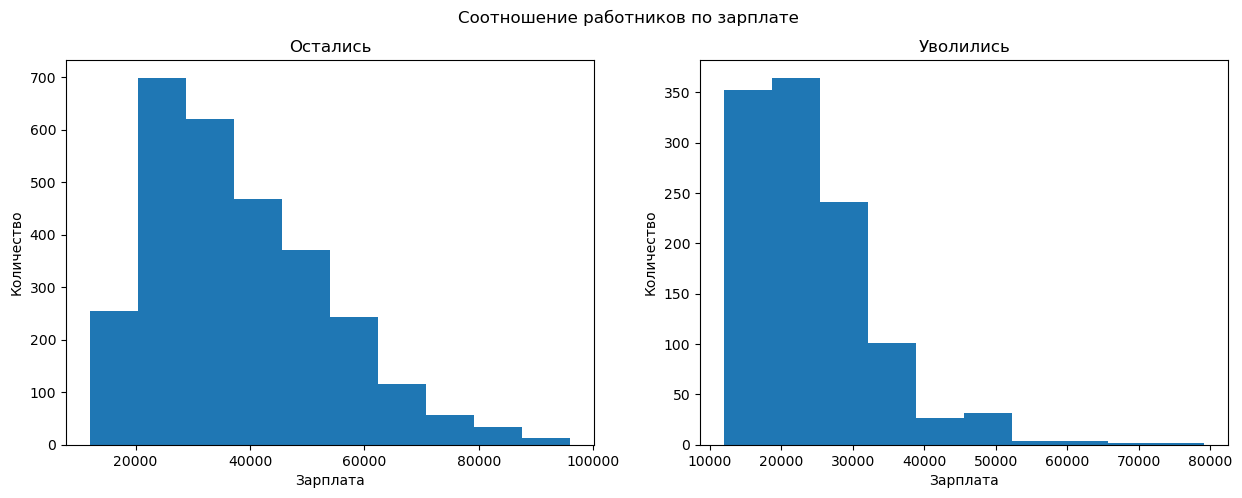

In [132]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Соотношение работников по зарплате')

plt.subplot(1, 2, 1)
plt.hist(stayed['salary'])
plt.title('Остались')
plt.xlabel('Зарплата')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(dismissal['salary'])
plt.title('Уволились')
plt.xlabel('Зарплата')
plt.ylabel('Количество')

plt.show()

Крайне интересно получается с оставшимися. Уволились преимущественно сотрудники получающие зарплату до 30000 руб. Причина понятна, не хотели работать за такую зарплату. А вот среди тех кто остался наибольшее количество сотрудников получает зарплату от 20 до 40 тыс. руб. Могу предположить 3 варианта: 1 эти сотрудники работают для получения опыта и возможно для дальнейшего развития в компании. 2 эти сотрудники не сильно нуждаются в деньгах и работают ради удовольствия и 3 вариант их привлекают другие преимущества работы.

In [133]:
df_train['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [134]:
labels = ['sales', 'purchasing', 'marketing', 'technology', 'hr']

In [135]:
stayed_dept = stayed.pivot_table(index='dept',values='id',aggfunc='count')
dismissal_dept = dismissal.pivot_table(index='dept',values='id',aggfunc='count')

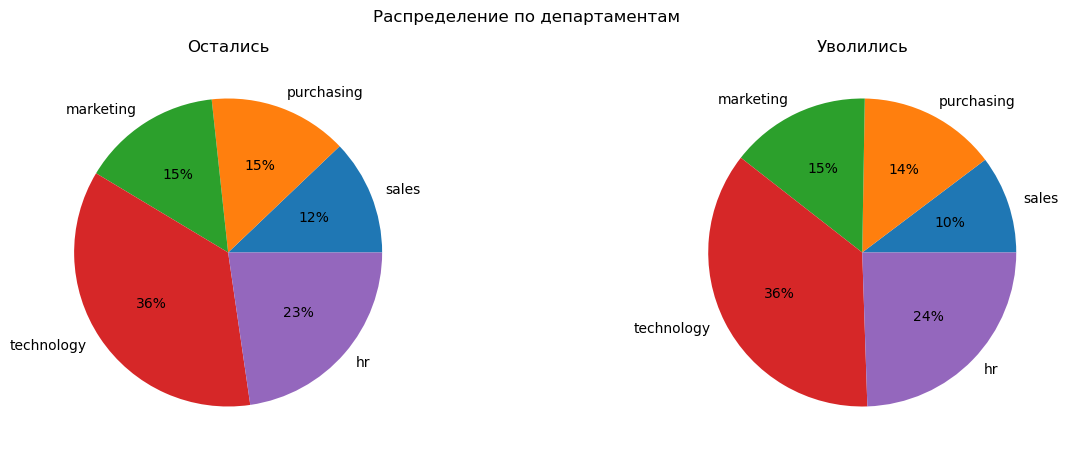

In [136]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по департаментам')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_dept['id'],labels=labels, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_dept['id'], labels=labels, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Распределение по департаметам примерно совпало, думаю это не сильно влияет на желание сотрудника остаться или уволиться.

In [137]:
df_train['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [138]:
labels2 = ['middle', 'junior', 'sinior']

In [139]:
stayed_level = stayed.pivot_table(index='level',values='id',aggfunc='count')
dismissal_level = dismissal.pivot_table(index='level',values='id',aggfunc='count')

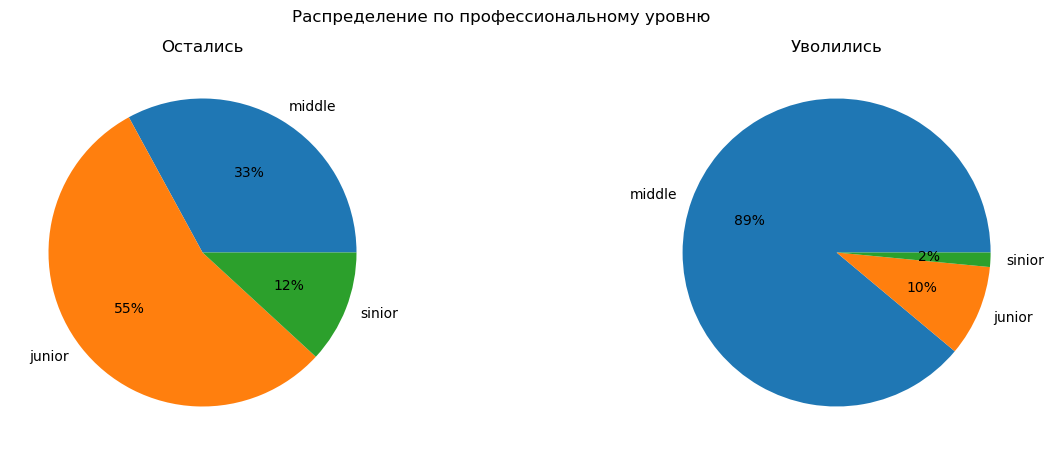

In [140]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по профессиональному уровню')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_level['id'],labels=labels2, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_level['id'], labels=labels2, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Видна явная закономерность, увольняются преимущественно сотрудники с уровнем middle. Думаю это связано с тем, что данные сотрудники получили необходимый опыт и находят работу в других компаниях. Возможно это связано с уровнем зарплаты.

In [141]:
df_train['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [142]:
labels3 = ['high', 'medium', 'low']

In [143]:
stayed_workload = stayed.pivot_table(index='workload',values='id',aggfunc='count')
dismissal_workload = dismissal.pivot_table(index='workload',values='id',aggfunc='count')

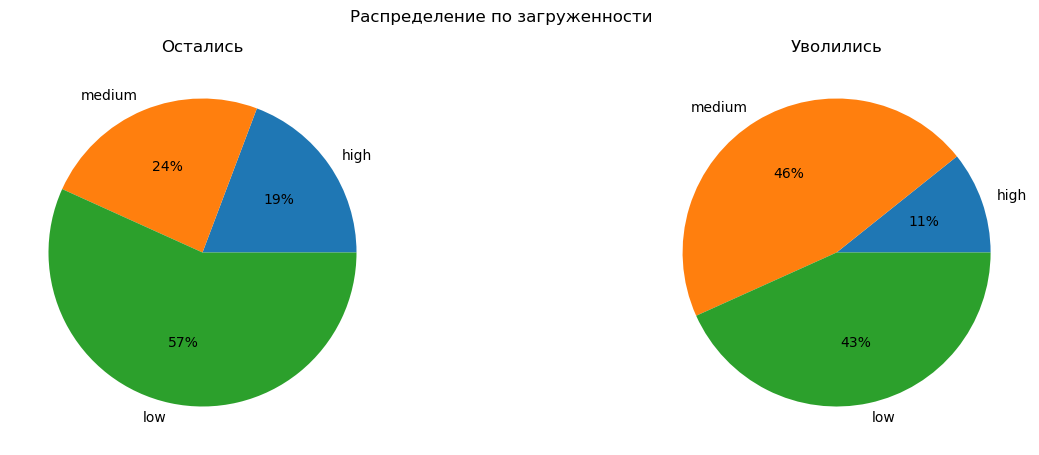

In [144]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по загруженности')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_workload['id'],labels=labels3, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_workload['id'], labels=labels3, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Абсолютное большинство оставшихся на работе сильно загруженны. В то же время среди уволишихся 43 % имеют среднюю нагрузку и 43 % высокую.

In [145]:
df_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [146]:
labels4 = ['no', 'yes']

In [147]:
stayed_last_year_promo = stayed.pivot_table(index='last_year_promo',values='id',aggfunc='count')
dismissal_last_year_promo = dismissal.pivot_table(index='last_year_promo',values='id',aggfunc='count')

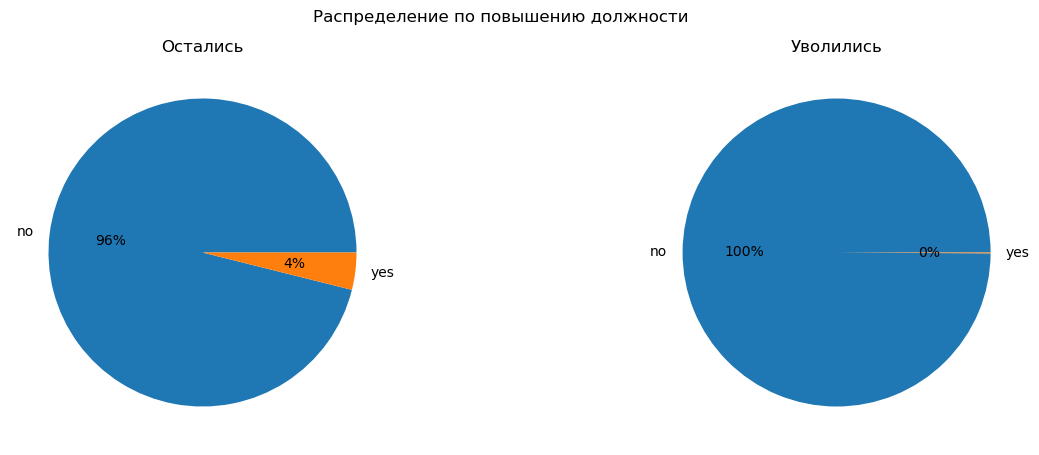

In [148]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по повышению должности')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_last_year_promo['id'],labels=labels4, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_last_year_promo['id'], labels=labels4, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Повышения по работе мало кто получил, а среди тех, кто уволился таких сотрудников нет.

In [149]:
stayed_last_year_violations = stayed.pivot_table(index='last_year_violations',values='id',aggfunc='count')
dismissal_last_year_violations = dismissal.pivot_table(index='last_year_violations',values='id',aggfunc='count')

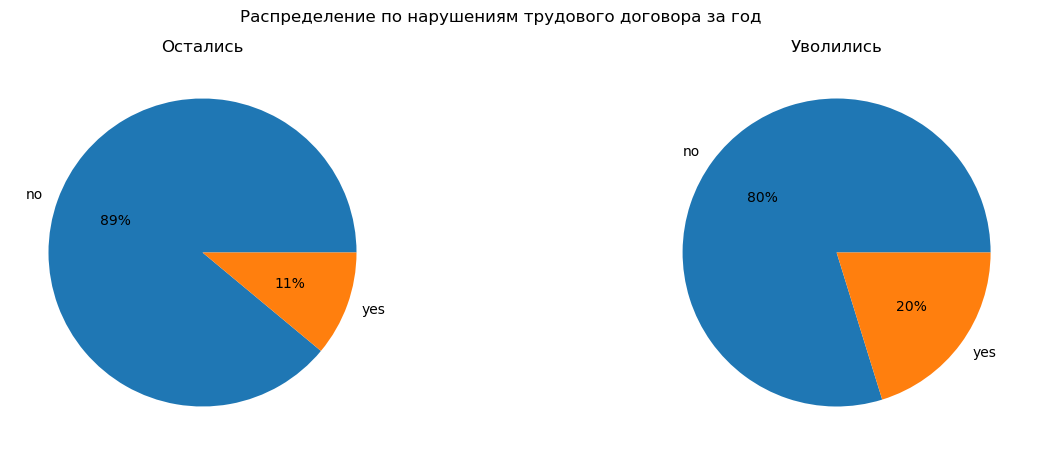

In [150]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по нарушениям трудового договора за год')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_last_year_violations['id'],labels=labels4, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_last_year_violations['id'], labels=labels4, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

20 % уволившися сотрудников нарушали трудовой договор за последний год. В то же время как 11 % от ставшихся тоже нарушали договор.

**Тестовые данные**

По тестовым данным таблица совпадает с 1 задачей. Графики повторять не вижу смысла. Поэтому строить их не буду. 

**Целевой признак**

Построим круговую диаграмму распределения целевого признака.

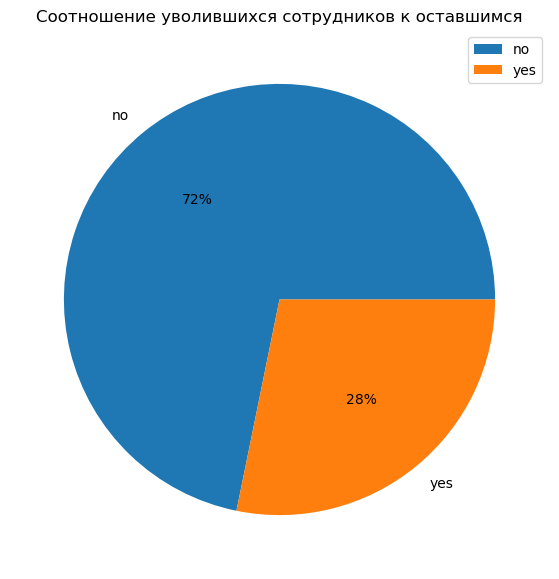

In [151]:
df_target.pivot_table(index='quit',values='id',aggfunc='count') \
  .plot.pie(y='id', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение уволившихся сотрудников к оставшимся")
plt.show()

28 % сотрудников уволилось.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

Нужно проверить утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Нам необходимо проверить это утверждение: визуализировать и сравнить распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. 

In [152]:
X_train_q = df_train.drop(['quit'], axis=1)

In [153]:
X_train_q = X_train_q.set_index('id')

In [154]:
df_train['job_satisfaction_rate'] = random_search_tree.predict(X_train_q)

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Отлично, что добавляется предсказание предыдущей модели.</font>

In [155]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.600000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [156]:
stayed_new = df_train.query("quit == 'no'")
dismissal_new = df_train.query("quit == 'yes'")

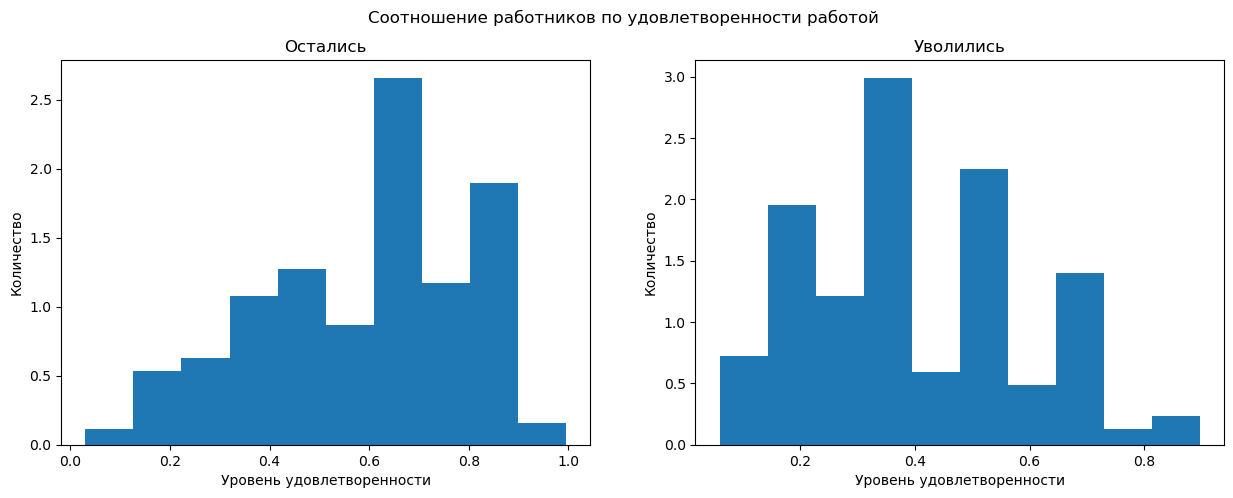

In [157]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Соотношение работников по удовлетворенности работой')

plt.subplot(1, 2, 1)
plt.hist(stayed_new['job_satisfaction_rate'], density=True)
plt.title('Остались')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(dismissal_new['job_satisfaction_rate'], density=True)
plt.title('Уволились')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество')

plt.show()

Думаю утверждение правильное, т.к. большинство уволившихся удовлетворены работой на 0,3 и 0,5. В то же время, как оставшиеся удовлетворены работой от 0,6 до 0,9.

**Тестовые данные**

Утверждения, что уровень удовлетворенности влияет на решение сотрудника уволиться верно, поэтому нам необходимо добавить в тестовые данные новый столбец job_satisfaction_rate.

In [158]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


Добавим целевой признак в тестовые данные.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

In [159]:
data_target

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69
...,...
997290,0.79
998548,0.76
998762,0.48


In [160]:
df_test = df_test.merge(df_target, on ='id', how='inner')

In [161]:
df_test = df_test.merge(data_target, on='id')

In [162]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,no,0.80
1,100480,marketing,junior,low,4,no,no,4,16800,no,0.84
2,100503,purchasing,middle,high,5,no,no,4,55200,no,0.79
3,100610,sales,middle,medium,5,no,no,4,43200,no,0.75
4,100692,sales,middle,high,6,no,no,4,48000,no,0.69


In [163]:
stayed_test = df_test.query("quit == 'no'")
dismissal_test = df_test.query("quit == 'yes'")

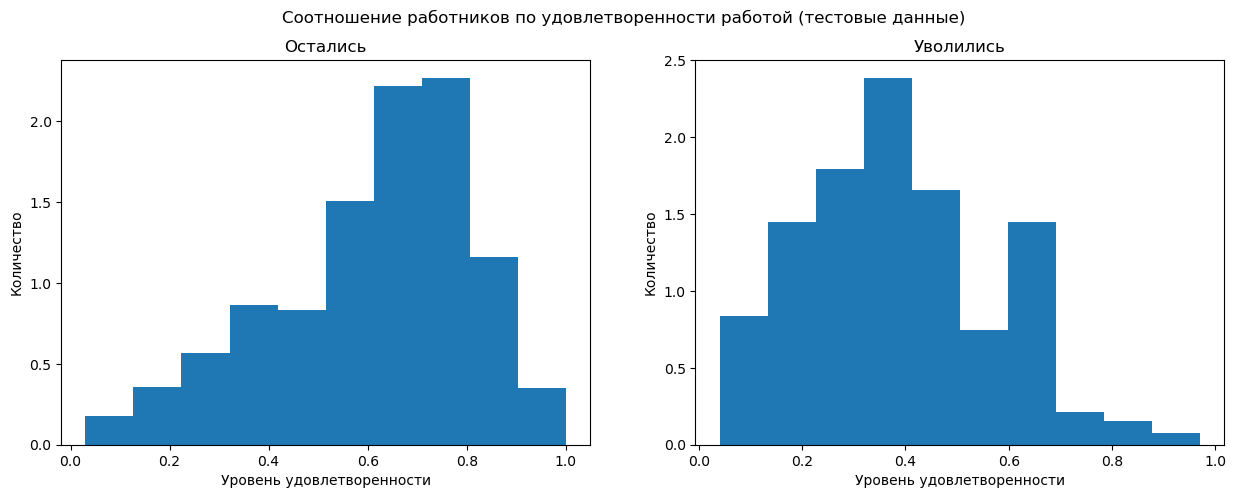

In [164]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Соотношение работников по удовлетворенности работой (тестовые данные)')

plt.subplot(1, 2, 1)
plt.hist(stayed_test['job_satisfaction_rate'], density=True)
plt.title('Остались')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(dismissal_test['job_satisfaction_rate'], density=True)
plt.title('Уволились')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Количество')

plt.show()

<font color='blue'><b>Комментарий ревьюера 3: </b></font> ⚠️\
<font color='darkorange'> Эту визуализацию нужно вывести в отдельный блок, как предложено в задании: п.3.3</font>


In [165]:
X_test_q = df_test.set_index('id')

In [166]:
df_test['job_satisfaction_rate'] = random_search_tree.predict(X_test_q)

На тестовых данных явно видно, что остались в основном сотрудники удовлетворенные работой.

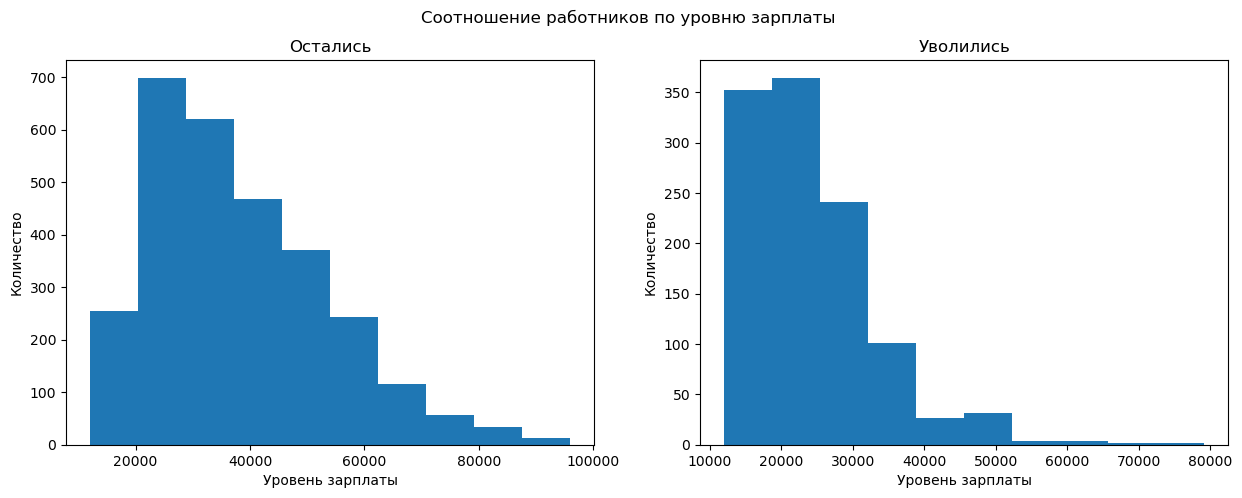

In [167]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Соотношение работников по уровню зарплаты')

plt.subplot(1, 2, 1)
plt.hist(stayed_new['salary'])
plt.title('Остались')
plt.xlabel('Уровень зарплаты')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(dismissal_new['salary'])
plt.title('Уволились')
plt.xlabel('Уровень зарплаты')
plt.ylabel('Количество')

plt.show()

Большинство уволившися получали зарплату до 30000, все логично. Вероятнее всего уволившися не устраивал уровень оплаты труда.

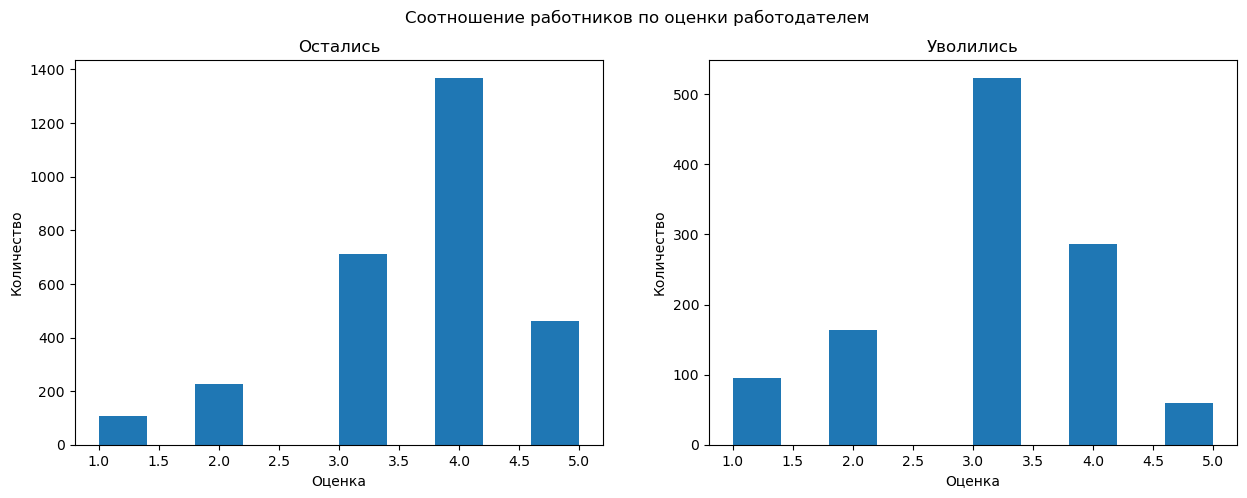

In [168]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Соотношение работников по оценки работодателем')

plt.subplot(1, 2, 1)
plt.hist(stayed_new['supervisor_evaluation'])
plt.title('Остались')
plt.xlabel('Оценка')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(dismissal_new['supervisor_evaluation'])
plt.title('Уволились')
plt.xlabel('Оценка')
plt.ylabel('Количество')

plt.show()

Большинство уволившихся получали оценку работодателя 3, остались же работники получающие оценку 4.

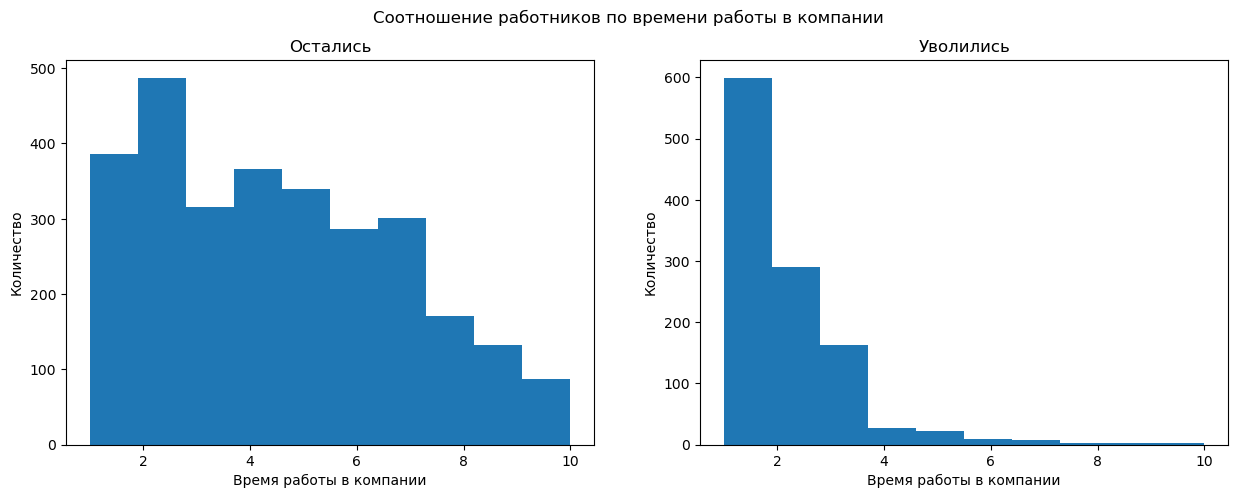

In [169]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Соотношение работников по времени работы в компании')

plt.subplot(1, 2, 1)
plt.hist(stayed_new['employment_years'])
plt.title('Остались')
plt.xlabel('Время работы в компании')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(dismissal_new['employment_years'])
plt.title('Уволились')
plt.xlabel('Время работы в компании')
plt.ylabel('Количество')

plt.show()

Уволились преимущественно сутрудники проработавшие до 2-х лет, причем абсолютное большинство в первый год работы. Возможно место не соответствовало ожиданиям работников, либо работа была связана не с тем, что изначально предполагалось. Ну и не стоит забывать про зарплату, возможно она тоже послужила катализатором к увольнению сотрудников.

In [170]:
stayed_dept_test = stayed_new.pivot_table(index='dept',values='id',aggfunc='count')
dismissal_dept_test = dismissal_new.pivot_table(index='dept',values='id',aggfunc='count')

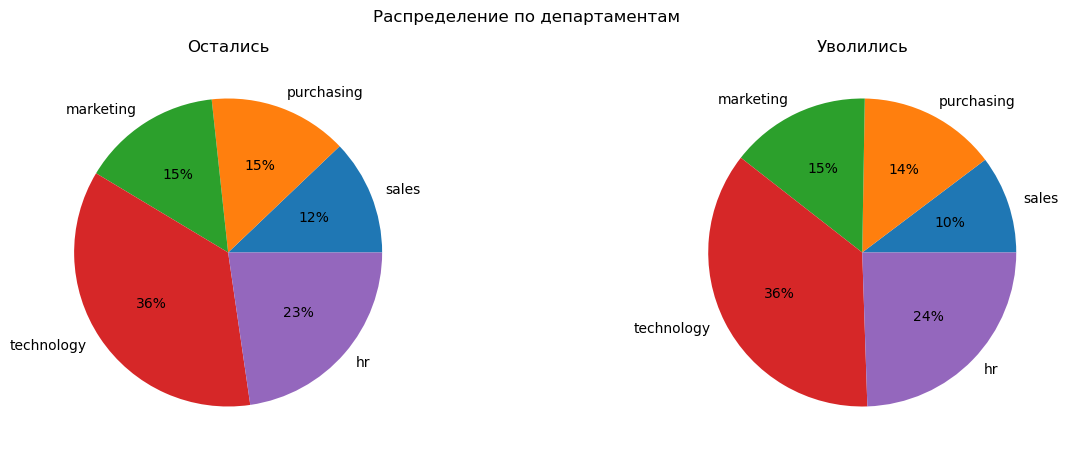

In [171]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по департаментам')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_dept_test['id'],labels=labels, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_dept_test['id'], labels=labels, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Работа в каком-либо департаменте не влияет на решение сотрудника увольняться или оставаться.

In [172]:
stayed_level_test = stayed_new.pivot_table(index='level',values='id',aggfunc='count')
dismissal_level_test = dismissal_new.pivot_table(index='level',values='id',aggfunc='count')

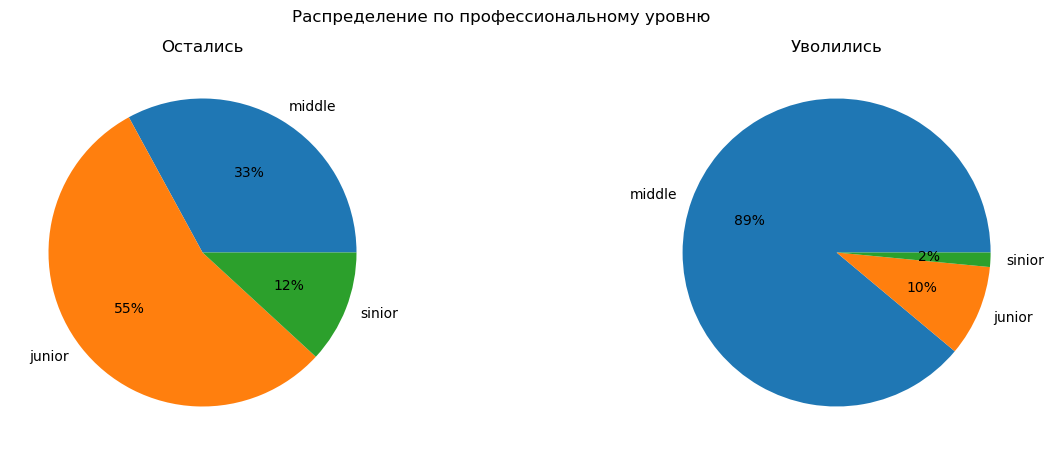

In [173]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по профессиональному уровню')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_level_test['id'],labels=labels2, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_level_test['id'], labels=labels2, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Большинство уволившися имели уровень профессионального навыка middle. В отличие от оставшися sinior уволилось всего 2 %. Думаю увольнение сотрудников middle вполне логично, необходимый навык уже получен, а перспектив в повышении должности и/или зарплаты не предвидится, поэтому сотрудники и увольняются.

In [174]:
stayed_workload_test = stayed_new.pivot_table(index='workload',values='id',aggfunc='count')
dismissal_workload_test = dismissal_new.pivot_table(index='workload',values='id',aggfunc='count')

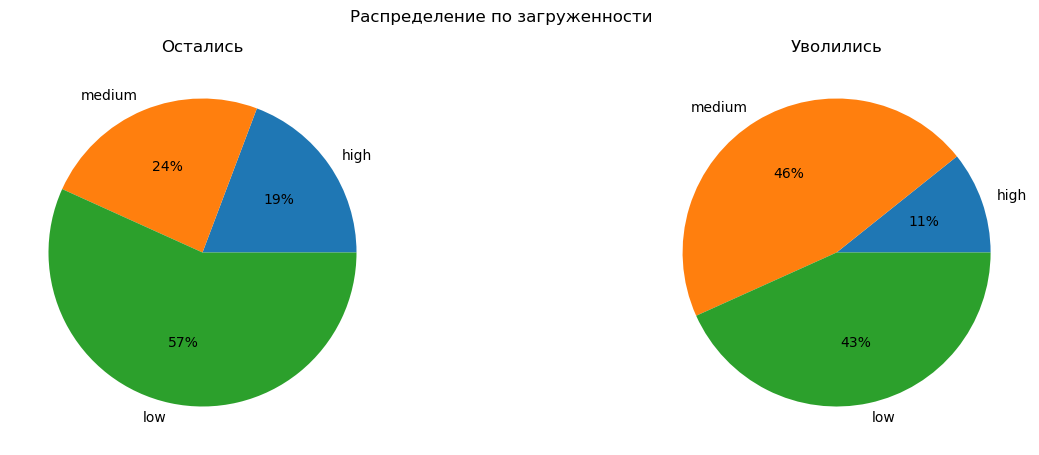

In [175]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по загруженности')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_workload_test['id'],labels=labels3, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_workload_test['id'], labels=labels3, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Распределение по загрузке уволившися сотрудников примерно поровну поделилось между medium и low. Крайне редко увольняются сотрудники с сильной загруженностью.

In [176]:
stayed_last_year_promo_test = stayed_new.pivot_table(index='last_year_promo',values='id',aggfunc='count')
dismissal_last_year_promo_test = dismissal_new.pivot_table(index='last_year_promo',values='id',aggfunc='count')

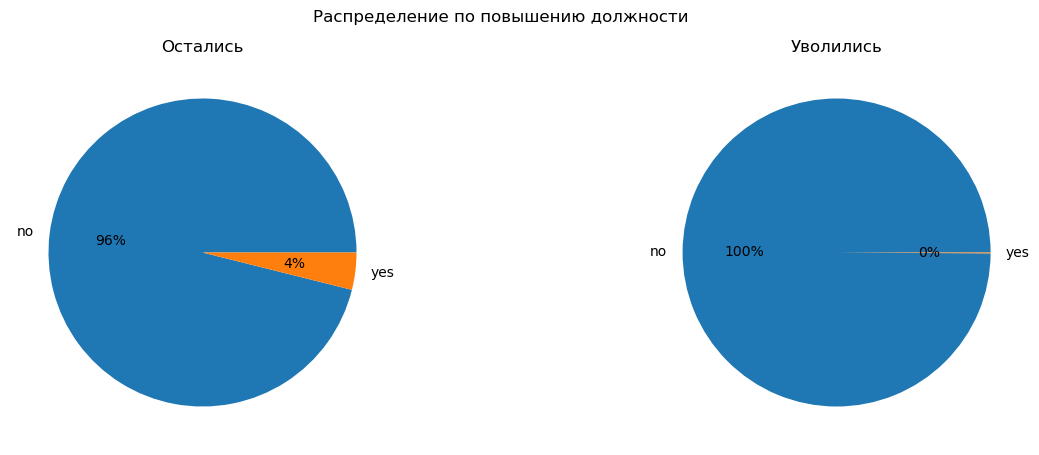

In [177]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по повышению должности')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_last_year_promo_test['id'],labels=labels4, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_last_year_promo_test['id'], labels=labels4, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Как и ожидалось среди уволившися нет, тех кто получал повышение в должности за последний год.

In [178]:
stayed_last_year_violations_test = stayed_new.pivot_table(index='last_year_violations',values='id',aggfunc='count')
dismissal_last_year_violations_test = dismissal_new.pivot_table(index='last_year_violations',values='id',aggfunc='count')

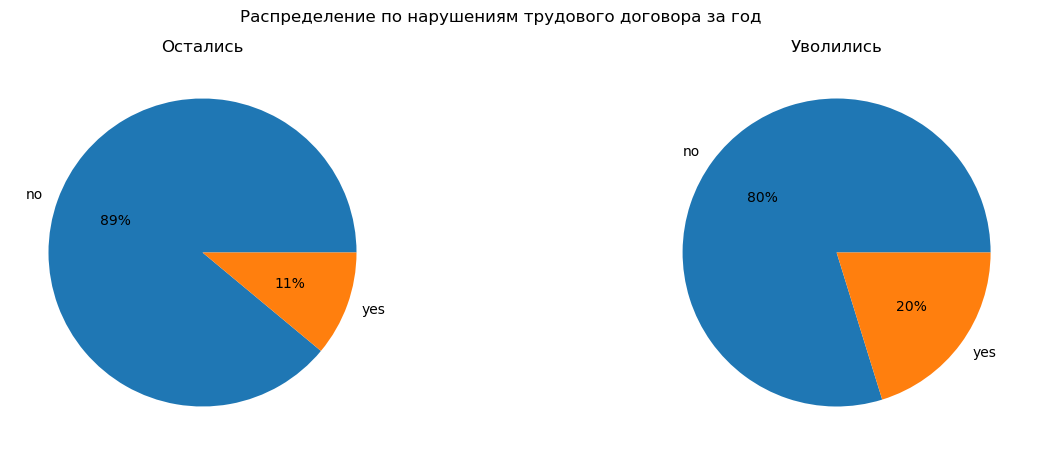

In [179]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.suptitle('Распределение по нарушениям трудового договора за год')
#plt.title('Снизилась')
df1 = ax1.pie(x=stayed_last_year_violations_test['id'],labels=labels4, autopct='%1.0f%%')
df2 = ax2.pie(x=dismissal_last_year_violations_test['id'], labels=labels4, autopct='%1.0f%%')
ax1.set_title('Остались')
ax2.set_title('Уволились');

Каждый 5 из уволившихся сотрудников нарушал трудовой договор за последний год, в то же время, как каждый 9 из оставшихся тоже нарушал трудовой договор.

    По исследовательскому анализу данных могу сделать следующие выводы:
    - 28 % сотрудников уволились в тренировочных данных.
    - В основном увольняются сотрудники на первых 3-х годах работы в компании, причем абсолютное большинство в 1 год работы. Однако, среди тех кто остался наибольшее количество сотрудников работает 2 года, это хороши признак, т.к.в первый год отсеились все не готовые работать сотрудники. Оставшиеся сотрудники после 2 года реже увольняются и возможно остатнутся работать дальше.
    - У тех кто остался преобладает оценка 4 за работу, кто остался 3. Наверное работники не особо старались и уже собирались уволиться.
    - Уволились преимущественно сотрудники получающие зарплату до 30000 руб. Причина понятна, не хотели работать за такую зарплату. А вот среди тех кто остался наибольшее количество сотрудников получает зарплату от 20 до 40 тыс. руб. Могу предположить 3 варианта: 1 эти сотрудники работают для получения опыта и возможно для дальнейшего развития в компании. 2 эти сотрудники не сильно нуждаются в деньгах и работают ради удовольствия и 3 вариант их привлекают другие преимущества работы.
    - Распределение по департаметам примерно совпало, думаю это не сильно влияет на желание сотрудника остаться или уволиться.
    - Видна явная закономерность, увольняются преимущественно сотрудники с уровнем middle. Думаю это связано с тем, что данные сотрудники получили необходимый опыт и находят работу в других компаниях. Возможно это связано с уровнем зарплаты.
    - Абсолютное большинство оставшихся на работе сильно загруженны. В то же время среди уволишихся 43 % имеют среднюю нагрузку и 43 % высокую.
    - Повышения по работе мало кто получил, а среди тех, кто уволился таких сотрудников нет.
    - 20 % уволившися сотрудников нарушали трудовой договор за последний год. В то же время как 11 % от ставшихся тоже нарушали договор.
    - уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.
    - На тестовых данных явно видно, что остались в основном сотрудники удовлетворенные работой.
    - Большинство уволившися получали зарплату до 30000, все логично. Вероятнее всего уволившися не устраивал уровень оплаты труда.
    - Большинство уволившихся получали оценку работодателя 3, остались же работники получающие оценку 4.
    - Уволились преимущественно сутрудники проработавшие до 2-х лет, причем абсолютное большинство в первый год работы. Возможно место не соответствовало ожиданиям работников, либо работа была связана не с тем, что изначально предполагалось. Ну и не стоит забывать про зарплату, возможно она тоже послужила катализатором к увольнению сотрудников.
    - Работа в каком-либо департаменте не влияет на решение сотрудника увольняться или оставаться.
    - Большинство уволившися имели уровень профессионального навыка middle. В отличие от оставшися sinior уволилось всего 2 %. Думаю увольнение сотрудников middle вполне логично, необходимый навык уже получен, а перспектив в повышении должности и/или зарплаты не предвидится, поэтому сотрудники и увольняются.
    - Распределение по загрузке уволившися сотрудников примерно поровну поделилось между medium и low. Крайне редко увольняются сотрудники с сильной загруженностью.
    - Как и ожидалось среди уволившися нет, тех кто получал повышение в должности за последний год.
    - Каждый 5 из уволившихся сотрудников нарушал трудовой договор за последний год, в то же время, как каждый 9 из оставшихся тоже нарушал трудовой договор.

## Шаг 4. Добавление нового входного признака

Так как получилась несостыковка в задании, новый признак был добавлен при исследовательском анализе данных. Посмотрим на полученные таблицы.

In [180]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.600000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [181]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,no,0.820000
1,100480,marketing,junior,low,4,no,no,4,16800,no,0.852000
2,100503,purchasing,middle,high,5,no,no,4,55200,no,0.746667
3,100610,sales,middle,medium,5,no,no,4,43200,no,0.814000
4,100692,sales,middle,high,6,no,no,4,48000,no,0.712500


Новый признак добавлен.

## Шаг 5. Подготовка данных

In [182]:
df_train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit', 'job_satisfaction_rate'],
      dtype='object')

Перенесем столбец 'quit' в последний столбец.

In [183]:
df_train = df_train[['id', 'dept', 'level', 'workload', 'employment_years',
                     'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
                     'salary', 'job_satisfaction_rate', 'quit']]

Произведем замену целевого признака в тренировочных и тестовых данных следющим образом yes на 1, no на 0.

In [184]:
df_train['quit'] = df_train['quit'].apply(lambda x: 1 if x == 'yes' else 0)

In [185]:
df_target['quit'] = df_target['quit'].apply(lambda x: 1 if x == 'yes' else 0)

Переведем столбец id в индекс.

In [186]:
df_train = df_train.set_index('id')

После удаления переведения столбца id нужно проверить данные на явные дубликаты.

In [187]:
print('Количество явных дубликатов в обучающих данных', df_train.duplicated().sum())

Количество явных дубликатов в обучающих данных 1413


In [188]:
df_train = df_train.drop_duplicates()

Проверяем дубликаты.

In [189]:
print('Количество явных дубликатов в обучающих данных', df_train.duplicated().sum())

Количество явных дубликатов в обучающих данных 0


Дубликаты удалены.

Задаем тренировочные данные.

In [190]:
X_train_quit = df_train.drop(['quit'], axis=1)
y_train_quit = df_train['quit']

Задаем тестовые данные.

In [191]:
df_test = df_test.set_index('id')

Разделим полученную таблицу на тестовые данные и целевой признак.

In [192]:
X_test_quit = df_test .drop(['quit'], axis=1)
y_test_quit = df_test ['quit']

In [193]:
type(X_train_quit)

pandas.core.frame.DataFrame

In [194]:
type(X_test_quit)

pandas.core.frame.DataFrame

In [195]:
df_train['workload']. unique()

array(['high', 'medium', 'low'], dtype=object)

Создаём списки

In [196]:
cols_ohe_2 = ['last_year_promo', 'last_year_violations', 'dept']
cols_ord_2 = ['level', 'workload']
cols_num_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Создаем итоговый паплайн.

In [197]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe_quit = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['middle', 'junior', 'sinior'],
                    ['high', 'medium', 'low']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor_quit = ColumnTransformer(
    [
        ('ohe', ohe_pipe_quit, cols_ohe_2),
        ('ord', ord_pipe_quit, cols_ord_2),
        ('num', StandardScaler(), cols_num_2)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final4= Pipeline(
    [
        ('preprocessor', data_preprocessor_quit),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

pipe_final5= Pipeline(
    [
        ('preprocessor', data_preprocessor_quit),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

pipe_final6= Pipeline(
    [
        ('preprocessor', data_preprocessor_quit),
        ('models', RandomForestClassifier())
    ]
)

В этом пункте мы подготовили данные для дальнейшего прогнозирования, а также создали итоговый паплайн для кодирования столбцов данных.

## Шаг 6. Обучение модели

Создадим модель поиска гиперпараметров.

Первую модель создадим по модели дерева предсказания.

In [198]:
param_grid4 = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,11),
     'models__max_features': range(2,11),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    {'models': [SVC(random_state=RANDOM_STATE, probability=True)],
     'models__C':[0.1,1,10,100,1000],
     'models__kernel':['rbf', 'poly', 'sigmoid', 'linear'],
     'models__degree':[1,2,3,4,5,6],
     'models__gamma':[1,0.1,0.01,0.001,0.0001],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit = RandomizedSearchCV(
    pipe_final4, 
    param_grid4, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search_quit.fit(X_train_quit, y_train_quit)

print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по методу опорных векторов решений является модель SVC(C=1000, degree=2, gamma=0.1, kernel='poly', probability=True, random_state=13)
Метрика лучшей модели на тренировочной выборке: 0.905576680759334

Лучшими параметрами по дереву предсказания является модель SVC(C=1000, degree=2, gamma=0.1, kernel='poly', probability=True, random_state=13))]).

Метрика лучшей модели на тренировочной выборке: 0.9045828865817753

In [199]:
param_grid4 = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,11),
     'models__max_features': range(2,11),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit1 = RandomizedSearchCV(
    pipe_final4, 
    param_grid4, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search_quit1.fit(X_train_quit, y_train_quit)

print('Лучшая модель и её параметры:\n\n', randomized_search_quit1.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по дереву решений решений является модель DecisionTreeClassifier(max_depth=5, max_features=10, random_state=13))

Метрика лучшей модели на тренировочной выборке: 0.8936225288902747

In [200]:
param_grid4 = [
    
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit2 = RandomizedSearchCV(
    pipe_final4, 
    param_grid4, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search_quit2.fit(X_train_quit, y_train_quit)

print('Лучшая модель и её параметры:\n\n', randomized_search_quit2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по логистической регрессии решений является модель LogisticRegression(C=4, penalty='l1', random_state=13, solver='liblinear'))

Метрика лучшей модели на тренировочной выборке: 0.9041788708920956

In [201]:
param_grid4 = [
    
    {'models': [SVC(random_state=RANDOM_STATE, probability=True)],
     'models__C':[0.1,1,10,100,1000],
     'models__kernel':['rbf', 'poly', 'sigmoid', 'linear'],
     'models__degree':[1,2,3,4,5,6],
     'models__gamma':[1,0.1,0.01,0.001,0.0001],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit3 = RandomizedSearchCV(
    pipe_final4, 
    param_grid4, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search_quit3.fit(X_train_quit, y_train_quit)

print('Лучшая модель и её параметры:\n\n', randomized_search_quit3.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit3.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по методу опорных векторов решений является модель SVC(C=10, degree=1, gamma=0.1, kernel='linear', probability=True, random_state=13)

Метрика лучшей модели на тренировочной выборке: 0.9014640011503884

Вторая задача логическая регрессия.

In [202]:
param_grid5 = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,11),
     'models__max_features': range(2,11),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit_5 = RandomizedSearchCV(
    pipe_final5, 
    param_grid5, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_quit_5.fit(X_train_quit, y_train_quit)


 
print('Лучшая модель и её параметры:\n\n', randomized_search_quit_5.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit_5.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по дереву решений является модель DecisionTreeClassifier(max_depth=5, max_features=10, random_state=13)

Метрика лучшей модели на тренировочной выборке: 0.8936225288902747

In [203]:
param_grid5 = [

    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit_6 = RandomizedSearchCV(
    pipe_final5, 
    param_grid5, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_quit_6.fit(X_train_quit, y_train_quit)
 
print('Лучшая модель и её параметры:\n\n', randomized_search_quit_6.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit_6.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по логической регрессии является модель LogisticRegression(C=4, penalty='l1', random_state=13, solver='liblinear')

Метрика лучшей модели на тренировочной выборке: 0.9041788708920956

In [204]:
param_grid6 = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,11),
     'models__max_features': range(2,11),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit_7 = RandomizedSearchCV(
    pipe_final6, 
    param_grid6, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search_quit_7.fit(X_train_quit, y_train_quit)


 
print('Лучшая модель и её параметры:\n\n', randomized_search_quit_7.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit_7.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по дереву предсказания является модель DecisionTreeClassifier(max_depth=5, max_features=10, random_state=13))]

Метрика лучшей модели на тренировочной выборке: 0.8936225288902747

In [205]:
param_grid6 = [
 
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit_8 = RandomizedSearchCV(
    pipe_final6, 
    param_grid6, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search_quit_8.fit(X_train_quit, y_train_quit)


 
print('Лучшая модель и её параметры:\n\n', randomized_search_quit_8.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit_8.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по KNN предсказания является модель KNeighborsClassifier(n_neighbors=4

Метрика лучшей модели на тренировочной выборке: 0.8704870887394488

In [206]:
param_grid6 = [
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]
 
randomized_search_quit_9 = RandomizedSearchCV(
    pipe_final6, 
    param_grid6, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search_quit_9.fit(X_train_quit, y_train_quit)


 
print('Лучшая модель и её параметры:\n\n', randomized_search_quit_9.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit_9.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                         

Лучшими параметрами по логистической регрессии предсказания является модель LogisticRegression(C=4, penalty='l1', random_state=13, solver='liblinear')

Метрика лучшей модели на тренировочной выборке: 0.9041788708920956

**Посчитаем метрику ROC_AUC на лучшей модели**

In [207]:
y_test_pred_quit = randomized_search_quit.predict_proba(X_test_quit)[:, 1]
print ('Метрика ROC_AUC на тренировочной выборке первой модели:', roc_auc_score(y_test_quit, y_test_pred_quit))

Метрика ROC_AUC на тренировочной выборке первой модели: 0.9219209931053558


На лучшей модели выполнено условие задачи "Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке."

## Шаг 7. Выводы

По второй задаче: предсказание увольнения сотрудника из компании, можнос сделать следующие выводы:
1. Во второй задаче нам предосталены 3 таблицы с данными. 
    - В первой таблице представлены тренировочные данные. В таблице 10 столбцов 4000 строк,  пропусков нет. Ошибок в заполнении данных нет.
    - Во второй таблице тестовые данные, В ней 9 столбцов и 2000 строк,  пропуски в столбцах dept и level. Ошибка в столбце dept установлен пробел. Пробел был заменен на nan. Проверка данных осуществлялась в 1 задаче.
    - В третьей таблице данные о целевом признаке. В таблице 2000 строк и 2 столбца. Пропусков и ошибок нет.
2. По предобработке данных могу сказать следующее: 
    - Пропуски только в тестовых данных в столбцах dept и level. 
    - Явных дубликатов не выявлено.
    - Типы данных в норме.
    - Был написан паплайн для заполнения пропусков на наиболее часто встречающиеся значения.
3. По исследовательскому анализу данных могу сделать следующие выводы:
    - 28 % сотрудников уволились в тренировочных данных.
    - В основном увольняются сотрудники на первых 3-х годах работы в компании, причем абсолютное большинство в 1 год работы. Однако, среди тех кто остался наибольшее количество сотрудников работает 2 года, это хороши признак, т.к.в первый год отсеились все не готовые работать сотрудники. Оставшиеся сотрудники после 2 года реже увольняются и возможно остатнутся работать дальше.
    - У тех кто остался преобладает оценка 4 за работу, кто остался 3. Наверное работники не особо старались и уже собирались уволиться.
    - Уволились преимущественно сотрудники получающие зарплату до 30000 руб. Причина понятна, не хотели работать за такую зарплату. А вот среди тех кто остался наибольшее количество сотрудников получает зарплату от 20 до 40 тыс. руб. Могу предположить 3 варианта: 1 эти сотрудники работают для получения опыта и возможно для дальнейшего развития в компании. 2 эти сотрудники не сильно нуждаются в деньгах и работают ради удовольствия и 3 вариант их привлекают другие преимущества работы.
    - Распределение по департаметам примерно совпало, думаю это не сильно влияет на желание сотрудника остаться или уволиться.
    - Видна явная закономерность, увольняются преимущественно сотрудники с уровнем middle. Думаю это связано с тем, что данные сотрудники получили необходимый опыт и находят работу в других компаниях. Возможно это связано с уровнем зарплаты.
    - Абсолютное большинство оставшихся на работе сильно загруженны. В то же время среди уволишихся 43 % имеют среднюю нагрузку и 43 % высокую.
    - Повышения по работе мало кто получил, а среди тех, кто уволился таких сотрудников нет.
    - 20 % уволившися сотрудников нарушали трудовой договор за последний год. В то же время как 11 % от ставшихся тоже нарушали договор.
    - уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.
    - На тестовых данных явно видно, что остались в основном сотрудники удовлетворенные работой.
    - Большинство уволившися получали зарплату до 30000, все логично. Вероятнее всего уволившися не устраивал уровень оплаты труда.
    - Большинство уволившихся получали оценку работодателя 3, остались же работники получающие оценку 4.
    - Уволились преимущественно сутрудники проработавшие до 2-х лет, причем абсолютное большинство в первый год работы. Возможно место не соответствовало ожиданиям работников, либо работа была связана не с тем, что изначально предполагалось. Ну и не стоит забывать про зарплату, возможно она тоже послужила катализатором к увольнению сотрудников.
    - Работа в каком-либо департаменте не влияет на решение сотрудника увольняться или оставаться.
    - Большинство уволившися имели уровень профессионального навыка middle. В отличие от оставшися sinior уволилось всего 2 %. Думаю увольнение сотрудников middle вполне логично, необходимый навык уже получен, а перспектив в повышении должности и/или зарплаты не предвидится, поэтому сотрудники и увольняются.
    - Распределение по загрузке уволившися сотрудников примерно поровну поделилось между medium и low. Крайне редко увольняются сотрудники с сильной загруженностью.
    - Как и ожидалось среди уволившися нет, тех кто получал повышение в должности за последний год.
    - Каждый 5 из уволившихся сотрудников нарушал трудовой договор за последний год, в то же время, как каждый 9 из оставшихся тоже нарушал трудовой договор.
4. Добавлен новый входной признак "job_satisfaction_rate"
5. Была проведена подготовка данных для дальнейшего прогнозирования, а также создан итоговый паплайн для кодирования столбцов данных.
6. Лучшими параметрами по дереву предсказания является модель SVC(C=1000, degree=2, gamma=0.1, kernel='poly', probability=True, random_state=13))]). получились следующие метрики:
    - Метрика лучшей модели на тренировочной выборке: 0.905576680759334
    - Метрика ROC_AUC на тренировочной выборке первой модели: 0.9219209931053558. На первой модели выполнено условие задачи "Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке."

## Общий вывод

По первой задаче построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, можно сделать следующие выводы:
1. По итогам предобработки данных могу сделать следующие выводы:
    - Пропуски в таблицах data_train и data_test, общее количество незначительно и не превышает 1 % от общего массива данных. По техническому заданию их нужно будет заполнить в паплайне.
    - Явные дубликаты в данных не выявлены.
    - Заменен тип данных в столбце job_satisfaction_rate в 1 и 34 таблице на формат float32.
2. По итогам исследовательского анализа данных могу сказать следующее:
    1. По тренировочным данным:
        - 91 человек, довольно хороший костяк сотрудников работающих с начала работы компании.
        - Наибольшее количество сотрудников работает в компании до 3-х лет. Здесь возможно 2 варианта: либо 3 года назад началось масштабное расширение компании, что очень хорошо, либо сотрудники не задерживаются больше 3-х лет, что не очень хорошо. Возможные причины текучки кадров низкая зарплата, либо тяжелые условия труда.
        - Работодатель не особо щедр на оценки, большинство 3 и 4. Думаю это и есть причина того, что большинство персонала имеет стаж до 3-х лет.
        - Большинство сотрудников получают зарплату в пределах от 20 до 40 тыс. руб. Также имеется группа лиц получающих больше 80 тысяч, максимум же составляет 98400 руб. Думаю больше 80 тысяч получают хорошие специалисты, ну а максимальная заплата у директора.
        - Наибольшее количество сотрудников работает в продажах, 2 место занимают технологи. Значит компания занимается продажей чего либо.
        - Более половины сотрудников загружено на работе средне.
        - Большинство сотрудников новички и со средним опытом работы. Профессионалов всего 9 % от общего числа.
        - Всего 3 % сотрудников получили повышение за последний год. Думаю это не плохо, т.к. повышения даются либо в случае ухода начальника, что не очень хорошо, либо с открытием нового направления и увеличения штата, что не так часто бывает.
        - 14 % сотрудников за последний год нарушали трудовой договор. Нужно задуматься над данным показателем.
        - Наиболее сильно на целевой признак влияет показатель оценка работодателя. Но он не линейнозависим, т.е. больше 0,9 поэтому оставляем данные как есть.
    2. По тестовым данным:
        - Большинство сотрудников работают менее 4-х лет в компании.
        - Уровень зарплаты такой же как и в тренировочных данных.
        - Лидером по оценкам является 4-ка, второе место занимает 3-ка. Работодатель также оценивает сотрудников.
        - В тестовых данных также преобладают сотрудники с отдела продаж.
        - Загруженность на тестовых данных совпадает с тренировочными.
        - Также 3 % сотрудников получили за последний год повышение.
        - 14 % сотрудников нарушили трудовой договор за последний год.
    3. По целевым данным:
        - Большинство сотрудников желает остаться работать. И сомневаются стоит ли уходить. Пик наблюдается от 0.6 до 0.8.
3. Наилучшая модель с гиперпараметрами для предсказания RandomForestRegressor(max_depth=4, n_estimators=6)).
4. При обучении моделей было построено 2 модели: Линейная модель и Дерево решений. Могу сделать следющте выводы:
    - Для линейной модели наилучшее абсолютное отклонение равно 26,2 %. Лучшие параметры LinearRegression(fit_intercept=False).
    - Для Дерева решений абсолютное отклонение равно 15.08. Параметры модели DecisionTreeRegressor(max_depth=27, max_features=28, min_samples_split=6, random_state=13))]). Могу сделать вывод, что для наших данных больше подходит модель деревья решений.

По второй задаче: предсказание увольнения сотрудника из компании, можно сделать следующие выводы:
1. Во второй задаче нам предосталены 3 таблицы с данными. 
    - В первой таблице представлены тренировочные данные. В таблице 10 столбцов 4000 строк,  пропусков нет. Ошибок в заполнении данных нет.
    - Во второй таблице тестовые данные, В ней 9 столбцов и 2000 строк,  пропуски в столбцах dept и level. Ошибка в столбце dept установлен пробел. Пробел был заменен на nan. Проверка данных осуществлялась в 1 задаче.
    - В третьей таблице данные о целевом признаке. В таблице 2000 строк и 2 столбца. Пропусков и ошибок нет.
2. По предобработке данных могу сказать следующее: 
    - Пропуски только в тестовых данных в столбцах dept и level. 
    - Явных дубликатов не выявлено.
    - Типы данных в норме.
    - Был написан паплайн для заполнения пропусков на наиболее часто встречающиеся значения.
3. По исследовательскому анализу данных могу сделать следующие выводы:
    - 28 % сотрудников уволились в тренировочных данных.
    - В основном увольняются сотрудники на первых 3-х годах работы в компании, причем абсолютное большинство в 1 год работы. Однако, среди тех кто остался наибольшее количество сотрудников работает 2 года, это хороши признак, т.к.в первый год отсеились все не готовые работать сотрудники. Оставшиеся сотрудники после 2 года реже увольняются и возможно остатнутся работать дальше.
    - У тех кто остался преобладает оценка 4 за работу, кто остался 3. Наверное работники не особо старались и уже собирались уволиться.
    - Уволились преимущественно сотрудники получающие зарплату до 30000 руб. Причина понятна, не хотели работать за такую зарплату. А вот среди тех кто остался наибольшее количество сотрудников получает зарплату от 20 до 40 тыс. руб. Могу предположить 3 варианта: 1 эти сотрудники работают для получения опыта и возможно для дальнейшего развития в компании. 2 эти сотрудники не сильно нуждаются в деньгах и работают ради удовольствия и 3 вариант их привлекают другие преимущества работы.
    - Распределение по департаметам примерно совпало, думаю это не сильно влияет на желание сотрудника остаться или уволиться.
    - Видна явная закономерность, увольняются преимущественно сотрудники с уровнем middle. Думаю это связано с тем, что данные сотрудники получили необходимый опыт и находят работу в других компаниях. Возможно это связано с уровнем зарплаты.
    - Абсолютное большинство оставшихся на работе сильно загруженны. В то же время среди уволишихся 43 % имеют среднюю нагрузку и 43 % высокую.
    - Повышения по работе мало кто получил, а среди тех, кто уволился таких сотрудников нет.
    - 20 % уволившися сотрудников нарушали трудовой договор за последний год. В то же время как 11 % от ставшихся тоже нарушали договор.
    - уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.
    - На тестовых данных явно видно, что остались в основном сотрудники удовлетворенные работой.
    - Большинство уволившися получали зарплату до 30000, все логично. Вероятнее всего уволившися не устраивал уровень оплаты труда.
    - Большинство уволившихся получали оценку работодателя 3, остались же работники получающие оценку 4.
    - Уволились преимущественно сутрудники проработавшие до 2-х лет, причем абсолютное большинство в первый год работы. Возможно место не соответствовало ожиданиям работников, либо работа была связана не с тем, что изначально предполагалось. Ну и не стоит забывать про зарплату, возможно она тоже послужила катализатором к увольнению сотрудников.
    - Работа в каком-либо департаменте не влияет на решение сотрудника увольняться или оставаться.
    - Большинство уволившися имели уровень профессионального навыка middle. В отличие от оставшися sinior уволилось всего 2 %. Думаю увольнение сотрудников middle вполне логично, необходимый навык уже получен, а перспектив в повышении должности и/или зарплаты не предвидится, поэтому сотрудники и увольняются.
    - Распределение по загрузке уволившися сотрудников примерно поровну поделилось между medium и low. Крайне редко увольняются сотрудники с сильной загруженностью.
    - Как и ожидалось среди уволившися нет, тех кто получал повышение в должности за последний год.
    - Каждый 5 из уволившихся сотрудников нарушал трудовой договор за последний год, в то же время, как каждый 9 из оставшихся тоже нарушал трудовой договор.
4. Добавлен новый входной признак "job_satisfaction_rate"
5. Была проведена подготовка данных для дальнейшего прогнозирования, а также создан итоговый паплайн для кодирования столбцов данных.
6. Лучшими параметрами по дереву предсказания является модель SVC(C=1000, degree=2, gamma=0.1, kernel='poly', probability=True, random_state=13))]). получились следующие метрики:
    - Метрика лучшей модели на тренировочной выборке: 0.905576680759334
    - Метрика ROC_AUC на тренировочной выборке первой модели: 0.9219209931053558. На первой модели выполнено условие задачи "Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке."